# Image analysis with $\texttt{LieDetect}$

Henrique Hennes https://github.com/HLovisiEnnes \
Raphaël Tinarrage https://raphaeltinarrage.github.io/

See the repo at https://github.com/HLovisiEnnes/LieDetect and the article at https://arxiv.org/abs/2309.03086

- **I. Pixel permutations**
    - I.1. $\mathrm{SO}(2)$-action on translated gorillas
    - I.2. $T^2$-action on translated gorillas
    - I.3. $\mathrm{SO}(2)$-action on rotated gorillas
- **II. Rotation of 3D objects**
    - II.1. $\mathrm{SU(2)}$-action on armadillo in $\mathbb{R}^8$
        - II.1.1. Illustrate the different rotation methods
        - II.1.2. Orbit detection with 'mesh' method
        - II.1.3. Orbit detection with 'voxels' method
        - II.1.4. Orbit detection with 'kde' method
    - II.2. Detection of eigengaps
    - II.3. $\mathrm{SU(2)}$-action on armadillo in $\mathbb{R}^{15}$
- **III. Harmonic analysis**
    - III.1. Translated gorillas with gaussian filter
    - III.2. Learning rotation matrices from armadillo, voxels embedding
    - III.3. Learning rotation matrices from armadillo, KDE embedding

In [1]:
# Import LieDetect functions
from functions_20240715 import*

# Import libraries specific to this notebook
import open3d as o3d
import tensorflow as tf
import miniball, skimage, matplotlib.gridspec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

2024-07-25 17:18:17.801563: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-25 17:18:17.883786: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-25 17:18:17.972424: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 17:18:18.052974: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 17:18:18.076852: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-25 17:18:18.211822: I tensorflow/core/platform/cpu_feature_gu

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# I. Pixel permutations

## I.1. $\mathrm{SO}(2)$-action on translated gorillas

The RGB image has shape (130, 120, 3)
The point cloud (collection of translated images) has shape (130, 46800)


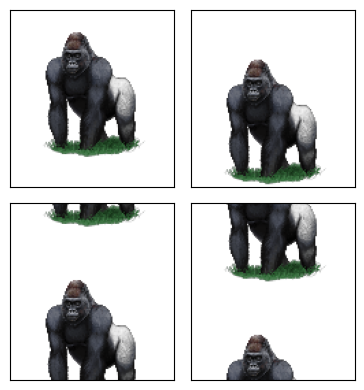

In [2]:
' Generate dataset - translated gorillas '

# Open image file and resize
img = plt.imread('Data/gorilla.png')
img = img[::7,::7,0:3]        # select 1 every 7 pixels
img = img[7:137,9:130]        # center image
nx, ny, _ = np.shape(img)
print('The RGB image has shape', np.shape(img))

# Translate image and flatten
X = [np.roll(img, i, 0).flatten() for i in range(nx)]
print('The point cloud (collection of translated images) has shape', np.shape(X))

# Plot a few images
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(4,4), tight_layout=True)
axs[0,0].imshow(X[0].reshape(np.shape(img)))
axs[0,1].imshow(X[20].reshape(np.shape(img)))
axs[1,0].imshow(X[40].reshape(np.shape(img)))
axs[1,1].imshow(X[80].reshape(np.shape(img)))
for ax in list(axs.flatten()): 
    ax.set_xticks([])
    ax.set_yticks([])
fig.savefig('Figures/gorilla_translation_SO(2)_sample.png',dpi=fig.dpi,bbox_inches='tight')

Covariance eigenvalues: [0.402, 0.402, 0.042, 0.042, 0.031, 0.031, 0.025, 0.025]
----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [7.222982671281235e-14, 0.03377510372489283, 0.033775104788048786, 0.06008581303335608]
Eigengap #1: 467606046726.147


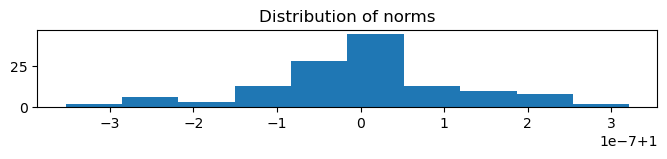

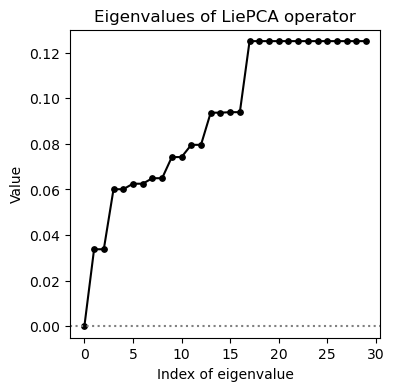

In [3]:
' Dimension reduction '

# Project in lower dimension via PCA and show eigenvalues
dim_pca = 8
Y = sklearn.decomposition.PCA(n_components=dim_pca).fit_transform(X)
PrintCovarianceEigenvalues(Y)

Y, Cov = Orthonormalize(Y)
PlotNormsDistribution(Y)

' LiePCA '

n_neighbors = 10
dim_LiePCA = 1
Sigma = GetLiePCAOperator(Y,n_neighbors,dim_LiePCA,method='localPCA',verbose=True)

# Plot Lie-PCA operator
vals = np.sort(np.real(np.linalg.eig(Sigma)[0]))[:30] #find eigenvalues and vectors of sigma as a matrix
fig = plt.figure(figsize=(4,4)); ax = fig.add_subplot()
ax.plot(range(len(vals)),vals,c='black'); ax.scatter(range(len(vals)), vals,c='black',s=15); 
ax.axhline(0,color='grey',linestyle='dotted'); 
ax.set_ylim((0-0.005,max(vals)+0.005)); ax.set_title('Eigenvalues of LiePCA operator');
ax.set_xlabel('Index of eigenvalue'); ax.set_ylabel('Value'); 
plt.show(); fig.savefig('Figures/gorilla_translation_SO(2)_LiePCA.png',dpi=fig.dpi,bbox_inches='tight');

----> Optimization problem via NormalForm for torus group <----
Number of frequencies to test: 205
The optimal frequencies found is ((1, 2, 3, 4),) with cost 0.034318196584873034
Non-symmetric Hausdorff distance from point cloud to estimated orbit: 0.008611894593638238 
Non-symmetric Hausdorff distance from estimated orbit to point cloud: 0.06609677824598115


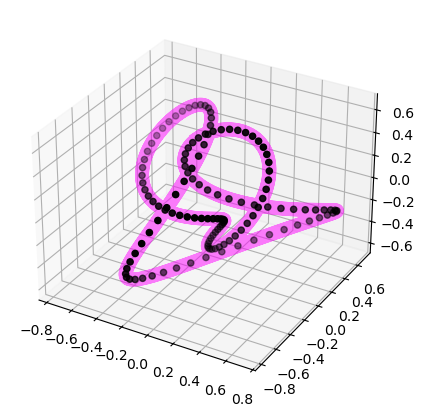

In [4]:
' LieDetect '

group, dim = 'torus', 1
ambient_dim = dim_pca
method_optim, frequency_max = 'NormalForm', 10
OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra(group,Sigma,dim,ambient_dim,frequency_max=frequency_max,method=method_optim,verbosity=1)

' Generate orbit and plot '

# Generate estimated orbit
n_points_orbit = 1000
x = Y[0,:] #initial point of X
Orbit = GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points=n_points_orbit, x=x,method='uniform')

# Compute non-symmetric Hausdorff
Hausdorff = scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0]
print('\x1b[1;31m'+'Non-symmetric Hausdorff distance from point cloud to estimated orbit:', Hausdorff,'\x1b[0m')
Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, Y)[0]
print('Non-symmetric Hausdorff distance from estimated orbit to point cloud:', Hausdorff)

# Plot orbit
pca = sklearn.decomposition.PCA(n_components=3)
Ypca = pca.fit_transform(Y)
fig = plt.figure(figsize=(5,5)); ax = fig.add_subplot(projection='3d')
ax.scatter(Ypca[:,0], Ypca[:,1], Ypca[:,2], c='black');
Orbitpca = pca.transform(Orbit)
ax.plot(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=10,alpha=0.5); 
fig.savefig('Figures/gorilla_translation_SO(2)_orbit.png',dpi=fig.dpi,bbox_inches='tight')

In [5]:
' Repeat the experiment for several embedding dimensions '

Scores = list()

for dim_pca in range(2,26+2,2):
    # Dimension reduction
    Y = sklearn.decomposition.PCA(n_components=dim_pca).fit_transform(X)
    Y, _ = Orthonormalize(Y)

    # LiePCA
    n_neighbors = 2
    # n_neighbors = 10
    dim_LiePCA = 1
    Sigma = GetLiePCAOperator(Y,n_neighbors,dim_LiePCA,method='localPCA',verbose=False)
    
    # LieDetect 
    group, dim = 'torus', 1
    ambient_dim = dim_pca
    method_optim, frequency_max = 'NormalForm', 20
    # method_optim, frequency_max = 'NormalForm', int(dim_pca/2)+1
    OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra(group,Sigma,dim,ambient_dim,frequency_max=frequency_max,method=method_optim,verbosity=1)
    
    # Generate orbit
    n_points_orbit = 1000
    x = Y[0,:] #initial point of X
    Orbit = GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points=n_points_orbit, x=x,method='uniform')
    Hausdorff = scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0]
    print('\x1b[1;31m'+'Non-symmetric Hausdorff distance from X to estimated orbit:', Hausdorff,'\x1b[0m')

    Scores.append([dim_pca, OptimalFrequencies, Hausdorff])

# Print scores in markdown and latex
IPython.display.clear_output()
str_markdown = '| Ambient dimension | Representation found | Hausdorff distance |\n| --- | --- | --- |\n'\
                +'\n'.join([str(score[0])+'|'+str(score[1][0])+'|'+'{:.4f}'.format(score[2])+'|' for score in Scores])
IPython.display.display_markdown(str_markdown, raw=True)
str_latex = '\\begin{longtable}{||c|l|c||}\\hline\\begin{tabular}{@{}c@{}}Ambient\\\\dimension\\end{tabular}&Representation found&\\begin{tabular}{@{}c@{}}Haudorff\\\\distance\\end{tabular}\\\\*\\hline'\
+'\\\\'.join([str(score[0])+'&'+str(score[1][0])+'&'+'{:.4f}'.format(score[2]) for score in Scores])\
+'\\\\*\\hline\\end{longtable}'
print(str_latex)

| Ambient dimension | Representation found | Hausdorff distance |
| --- | --- | --- |
2|(1,)|0.0031|
4|(1, 2)|0.0050|
6|(1, 2, 3)|0.0068|
8|(1, 2, 3, 4)|0.0086|
10|(1, 2, 3, 4, 5)|0.0104|
12|(1, 2, 3, 4, 5, 6)|0.0122|
14|(1, 2, 3, 4, 5, 6, 8)|0.0148|
16|(1, 2, 3, 4, 5, 6, 7, 8)|0.0159|
18|(1, 2, 3, 4, 5, 6, 7, 8, 10)|0.0183|
20|(1, 2, 3, 4, 5, 6, 7, 8, 9, 10)|0.0207|
22|(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)|0.0307|
24|(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)|0.0434|
26|(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)|0.5733|

\begin{longtable}{||c|l|c||}\hline\begin{tabular}{@{}c@{}}Ambient\\dimension\end{tabular}&Representation found&\begin{tabular}{@{}c@{}}Haudorff\\distance\end{tabular}\\*\hline2&(1,)&0.0031\\4&(1, 2)&0.0050\\6&(1, 2, 3)&0.0068\\8&(1, 2, 3, 4)&0.0086\\10&(1, 2, 3, 4, 5)&0.0104\\12&(1, 2, 3, 4, 5, 6)&0.0122\\14&(1, 2, 3, 4, 5, 6, 8)&0.0148\\16&(1, 2, 3, 4, 5, 6, 7, 8)&0.0159\\18&(1, 2, 3, 4, 5, 6, 7, 8, 10)&0.0183\\20&(1, 2, 3, 4, 5, 6, 7, 8, 9, 10)&0.0207\\22&(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)&0.0307\\24&(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)&0.0434\\26&(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)&0.5733\\*\hline\end{longtable}


## I.2. $T^2$-action on translated gorillas

The RGB image has shape (130, 120, 3)
The point cloud (collection of translated images) has shape (3900, 46800)


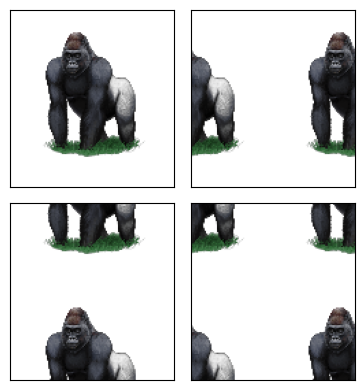

In [6]:
' Generate dataset - translated gorillas '

# Open image file and resize
img = plt.imread('Data/gorilla.png')
img = img[::7,::7,0:3]        # select 1 every 7 pixels
img = img[7:137,9:130]        # center image
nx, ny, _ = np.shape(img)
print('The RGB image has shape', np.shape(img))

# Translate image and flatten
X = [np.roll(np.roll(img, i, 0), j, 1).flatten() for i in range(0,nx,2) for j in range(0,ny,2)]
print('The point cloud (collection of translated images) has shape', np.shape(X))

# Plot a few images
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(4,4), tight_layout=True)
axs[0,0].imshow(X[0].reshape(np.shape(img)))
axs[0,1].imshow(X[30].reshape(np.shape(img)))
axs[1,0].imshow(X[1800].reshape(np.shape(img)))
axs[1,1].imshow(X[1830].reshape(np.shape(img)))
for ax in list(axs.flatten()): 
    ax.set_xticks([])
    ax.set_yticks([])
fig.savefig('Figures/gorilla_translation_T2_sample.png',dpi=fig.dpi,bbox_inches='tight')

Covariance eigenvalues: [0.228, 0.228, 0.142, 0.142, 0.108, 0.108, 0.022, 0.022]
----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [4.237514671150431e-10, 5.651100226544704e-09, 0.04125177002628023, 0.04125177136452355]
Eigengap #2: 7299776.746572254


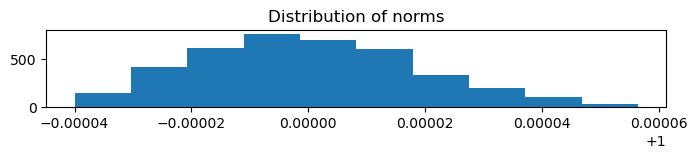

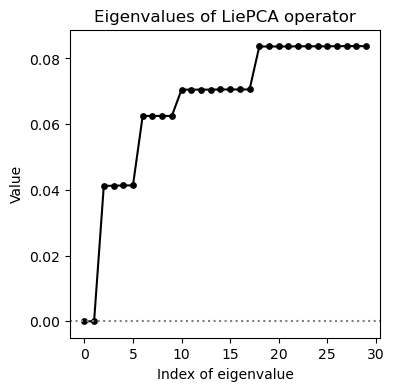

In [7]:
' Dimension reduction '

# Project in lower dimension via PCA and show eigenvalues
dim_pca = 8
Y = sklearn.decomposition.PCA(n_components=dim_pca).fit_transform(X)
PrintCovarianceEigenvalues(Y)

Y, Cov = Orthonormalize(Y)
PlotNormsDistribution(Y)

' LiePCA '

n_neighbors = 50
dim_LiePCA = 2
Sigma = GetLiePCAOperator(Y,n_neighbors,dim_LiePCA,method='localPCA',verbose=True)

# Plot Lie-PCA operator
vals = np.sort(np.real(np.linalg.eig(Sigma)[0]))[:30] #find eigenvalues and vectors of sigma as a matrix
fig = plt.figure(figsize=(4,4)); ax = fig.add_subplot()
ax.plot(range(len(vals)),vals,c='black'); ax.scatter(range(len(vals)), vals,c='black',s=15); 
ax.axhline(0,color='grey',linestyle='dotted'); 
ax.set_ylim((0-0.005,max(vals)+0.005)); ax.set_title('Eigenvalues of LiePCA operator');
ax.set_xlabel('Index of eigenvalue'); ax.set_ylabel('Value'); 
fig.savefig('Figures/gorilla_translation_T2_LiePCA.png',dpi=fig.dpi,bbox_inches='tight')

----> Optimization problem via NormalForm for torus group <----
Number of frequencies to test: 70
The optimal frequencies found is ((0, 1, -1, 1), (1, 0, -1, 2)) with cost 0.012444846583248381
Non-symmetric Hausdorff distance from point cloud to estimated orbit: 0.0623870592401896 
Non-symmetric Hausdorff distance from estimated orbit to point cloud: 0.061490249024751566


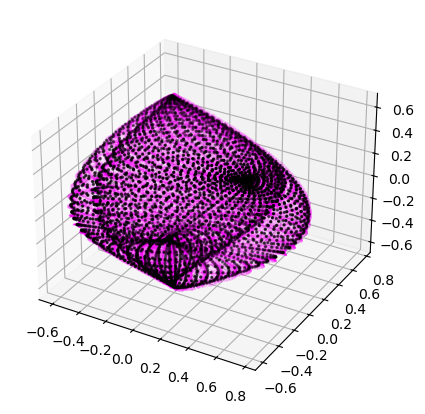

In [8]:
' LieDetect '

group, dim = 'torus', 2
ambient_dim = dim_pca
method_optim, frequency_max = 'NormalForm', 2
OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra(group,Sigma,dim,ambient_dim,frequency_max=frequency_max,method=method_optim,verbosity=1)

' Generate orbit and plot '

# Generate estimated orbit
n_points_orbit = 150
x = Y[0,:] #initial point
Orbit = GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points=n_points_orbit, x=x,method='uniform')

# Compute non-symmetric Hausdorff
Hausdorff = scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0]
print('\x1b[1;31m'+'Non-symmetric Hausdorff distance from point cloud to estimated orbit:', Hausdorff,'\x1b[0m')
Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, Y)[0]
print('Non-symmetric Hausdorff distance from estimated orbit to point cloud:', Hausdorff)

# Plot orbit
pca = sklearn.decomposition.PCA(n_components=3)
Ypca = pca.fit_transform(Y)
fig = plt.figure(figsize=(5,5)); ax = fig.add_subplot(projection='3d')
ax.scatter(Ypca[:,0], Ypca[:,1], Ypca[:,2], c='black', s=2);
Orbitpca = pca.transform(Orbit)
ax.plot(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=0.5, alpha=0.1,marker="3");
fig.savefig('Figures/gorilla_translation_T2_orbit.png',dpi=fig.dpi,bbox_inches='tight');

In [9]:
' Repeat the experiment for several embedding dimensions '

Scores = list()

for dim_pca in range(4,14+2,2):
    # Dimension reduction
    Y = sklearn.decomposition.PCA(n_components=dim_pca).fit_transform(X)
    Y, _ = Orthonormalize(Y)

    # LiePCA
    n_neighbors = 50
    dim_LiePCA = 2
    Sigma = GetLiePCAOperator(Y,n_neighbors,dim_LiePCA,method='localPCA',verbose=False)
    
    # LieDetect 
    group, dim = 'torus', 2
    ambient_dim = dim_pca
    method_optim, frequency_max = 'NormalForm', 2
    OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra(group,Sigma,dim,ambient_dim,frequency_max=frequency_max,method=method_optim,verbosity=1)
    
    # Generate orbit
    n_points_orbit = 150
    x = Y[0,:] #initial point
    Orbit = GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points=n_points_orbit, x=x,method='uniform')
    Hausdorff = scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0]
    print('\x1b[1;31m'+'Non-symmetric Hausdorff distance from X to estimated orbit:', Hausdorff,'\x1b[0m')

    Scores.append([dim_pca, OptimalFrequencies, Hausdorff])

# Print scores in markdown and latex
IPython.display.clear_output()
str_markdown = '| Ambient dimension | Representation found | Hausdorff distance |\n| --- | --- | --- |\n'\
                +'\n'.join([str(score[0])+'|'+str(score[1])+'|'+'{:.4f}'.format(score[2])+'|' for score in Scores])
IPython.display.display_markdown(str_markdown, raw=True)
str_latex = '\\begin{longtable}{||c|l|c||}\\hline\\begin{tabular}{@{}c@{}}Ambient\\\\dimension\\end{tabular}&Representation found&\\begin{tabular}{@{}c@{}}Haudorff\\\\distance\\end{tabular}\\\\*\\hline'\
+'\\\\'.join([str(score[0])+'&'+str(score[1])+'&'+'{:.4f}'.format(score[2]) for score in Scores])\
+'\\\\*\\hline\\end{longtable}'
print(str_latex)

| Ambient dimension | Representation found | Hausdorff distance |
| --- | --- | --- |
4|((0, 1), (1, 0))|0.0383|
6|((2, 1, -1), (1, 1, 0))|0.0506|
8|((-1, 1, 1, 0), (-2, 0, 1, 1))|0.0624|
10|((1, 2, -2, 1, 0), (0, 1, -2, 1, -1))|0.0773|
12|((-1, 0, 2, 2, 1, 1), (-2, -1, 2, 1, 1, 0))|0.0404|
14|((-1, 1, 2, 1, -2, -2, 0), (0, 1, 2, 2, -1, 0, 1))|0.8168|

\begin{longtable}{||c|l|c||}\hline\begin{tabular}{@{}c@{}}Ambient\\dimension\end{tabular}&Representation found&\begin{tabular}{@{}c@{}}Haudorff\\distance\end{tabular}\\*\hline4&((0, 1), (1, 0))&0.0383\\6&((2, 1, -1), (1, 1, 0))&0.0506\\8&((-1, 1, 1, 0), (-2, 0, 1, 1))&0.0624\\10&((1, 2, -2, 1, 0), (0, 1, -2, 1, -1))&0.0773\\12&((-1, 0, 2, 2, 1, 1), (-2, -1, 2, 1, 1, 0))&0.0404\\14&((-1, 1, 2, 1, -2, -2, 0), (0, 1, 2, 2, -1, 0, 1))&0.8168\\*\hline\end{longtable}


## I.3. $\mathrm{SO}(2)$-action on rotated gorillas

The RGB image has shape (130, 120, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0594908..1.1517092].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05296135..1.1479323].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.059629083..1.1470596].


The point cloud (collection of rotated images) has shape (360, 46800)


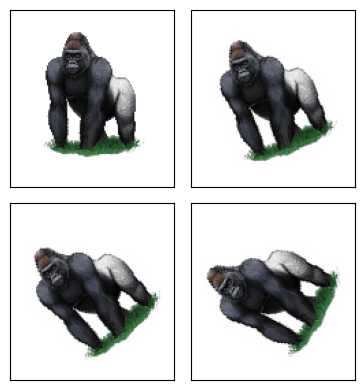

In [10]:
' Generate dataset - rotated gorillas '

# Open image file and resize
img = plt.imread('Data/gorilla.png')
img = img[::7,::7,0:3]        # select 1 every 7 pixels
img = img[7:137,9:130]        # center image
nx, ny, _ = np.shape(img)
print('The RGB image has shape', np.shape(img))

# Translate image and flatten
X = [1-scipy.ndimage.rotate(1-img, i, reshape=False).flatten() for i in range(360)]
print('The point cloud (collection of rotated images) has shape', np.shape(X))

# Plot a few images
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(4,4), tight_layout=True)
axs[0,0].imshow(X[0].reshape(np.shape(img)))
axs[0,1].imshow(X[20].reshape(np.shape(img)))
axs[1,0].imshow(X[40].reshape(np.shape(img)))
axs[1,1].imshow(X[60].reshape(np.shape(img)))
for ax in list(axs.flatten()): 
    ax.set_xticks([])
    ax.set_yticks([])
fig.savefig('Figures/gorilla_rotation_sample.png',dpi=fig.dpi,bbox_inches='tight')

Covariance eigenvalues: [0.155, 0.155, 0.11, 0.11, 0.041, 0.041, 0.04, 0.04, 0.038, 0.038, 0.026, 0.026, 0.02, 0.02, 0.014, 0.014, 0.013, 0.013, 0.01, 0.01, 0.009, 0.009, 0.008, 0.008, 0.005, 0.005, 0.004, 0.004, 0.003, 0.003, 0.003, 0.003]
----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [4.643476541718334e-06, 0.0026493653356078123, 0.002674819083777535, 0.005005569941344413]
Eigengap #1: 570.5564164705365


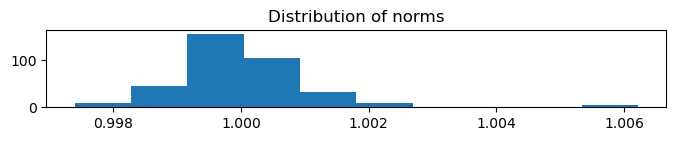

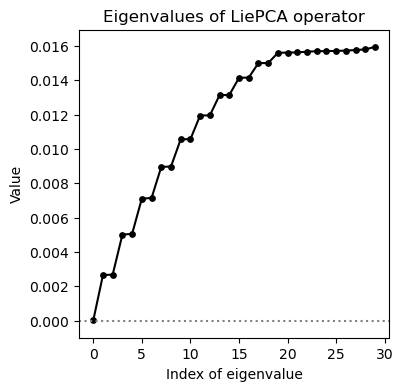

In [11]:
' Dimension reduction '

# Project in lower dimension via PCA and show eigenvalues
dim_pca = 32
Y = sklearn.decomposition.PCA(n_components=dim_pca).fit_transform(X)
PrintCovarianceEigenvalues(Y)

# Orthonormalize
Y, Cov = Orthonormalize(Y)
PlotNormsDistribution(Y)

' LiePCA '

n_neighbors = 2
dim_LiePCA = 1
Sigma = GetLiePCAOperator(Y,n_neighbors,dim_LiePCA,method='localPCA',verbose=True)

# Plot Lie-PCA operator
vals = np.sort(np.real(np.linalg.eig(Sigma)[0]))[:30] #find eigenvalues and vectors of sigma as a matrix
fig = plt.figure(figsize=(4,4)); ax = fig.add_subplot()
ax.plot(range(len(vals)),vals,c='black'); ax.scatter(range(len(vals)), vals,c='black',s=15); 
ax.axhline(0,color='grey',linestyle='dotted'); 
ax.set_ylim((0-0.001,max(vals)+0.001)); ax.set_title('Eigenvalues of LiePCA operator');
ax.set_xlabel('Index of eigenvalue'); ax.set_ylabel('Value'); 
fig.savefig('Figures/gorilla_rotation_LiePCA.png',dpi=fig.dpi,bbox_inches='tight')

----> Optimization problem via NormalForm for torus group <----
Number of frequencies to test: 4845
The optimal frequencies found is ((1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16),) with cost 0.0036579342518113455
Non-symmetric Hausdorff distance from point cloud to estimated orbit: 0.031932874218065406 
Non-symmetric Hausdorff distance from estimated orbit to point cloud: 0.08505118585331707
Typical distance between points: 0.1703799772758333


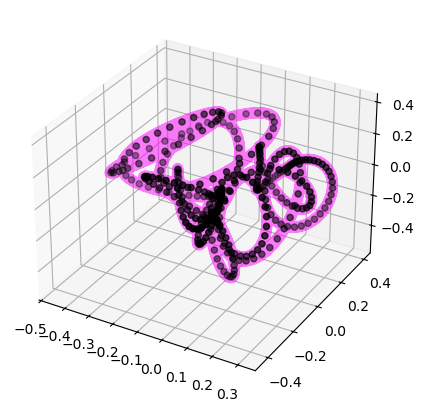

In [12]:
' LieDetect '

group, dim = 'torus', 1
ambient_dim = dim_pca
method_optim, frequency_max = 'NormalForm', 20
OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra(group,Sigma,dim,ambient_dim,frequency_max=frequency_max,method=method_optim,verbosity=1)

' Generate orbit and plot '

# Generate estimated orbit
n_points_orbit = 1000
x = Y[0,:] #initial point of X
Orbit = GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points=n_points_orbit, x=x,method='uniform')

# Compute non-symmetric Hausdorff
Hausdorff = scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0]
print('\x1b[1;31m'+'Non-symmetric Hausdorff distance from point cloud to estimated orbit:', Hausdorff,'\x1b[0m')
Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, Y)[0]
print('Non-symmetric Hausdorff distance from estimated orbit to point cloud:', Hausdorff)

# Plot orbit
pca = sklearn.decomposition.PCA(n_components=3)
Ypca = pca.fit_transform(Y)
fig = plt.figure(figsize=(5,5)); ax = fig.add_subplot(projection='3d')
ax.scatter(Ypca[:,0], Ypca[:,1], Ypca[:,2], c='black');
Orbitpca = pca.transform(Orbit)
ax.plot(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=8,alpha=0.5); 
fig.savefig('Figures/gorilla_rotation_orbit.png',dpi=fig.dpi,bbox_inches='tight')

# Typical distance between points
print('Typical distance between points:', max([np.linalg.norm(Y[i,:]-Y[i+1,:]) for i in range(np.shape(Y)[0]-1)]))

In [13]:
' Repeat the experiment for several embedding dimensions '

Scores = list()

for dim_pca in range(2,34+2,2):
    # Dimension reduction
    Y = sklearn.decomposition.PCA(n_components=dim_pca).fit_transform(X)
    Y, _ = Orthonormalize(Y)

    # LiePCA
    n_neighbors = 2
    dim_LiePCA = 1
    Sigma = GetLiePCAOperator(Y,n_neighbors,dim_LiePCA,method='localPCA',verbose=False)
    
    # LieDetect 
    group, dim = 'torus', 1
    ambient_dim = dim_pca
    # method_optim, frequency_max = 'NormalForm', 25
    method_optim, frequency_max = 'NormalForm', 25
    OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra(group,Sigma,dim,ambient_dim,frequency_max=frequency_max,method=method_optim,verbosity=1)
    
    # Generate orbit
    n_points_orbit = 1000
    x = Y[0,:] #initial point of X
    Orbit = GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points=n_points_orbit, x=x,method='uniform')
    Hausdorff = scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0]
    print('\x1b[1;31m'+'Non-symmetric Hausdorff distance from X to estimated orbit:', Hausdorff,'\x1b[0m')

    Scores.append([dim_pca, OptimalFrequencies, Hausdorff])

# Print scores in markdown and latex
IPython.display.clear_output()
str_markdown = '| Ambient dimension | Representation found | Hausdorff distance |\n| --- | --- | --- |\n'\
                +'\n'.join([str(score[0])+'|'+str(score[1][0])+'|'+'{:.4f}'.format(score[2])+'|' for score in Scores])
IPython.display.display_markdown(str_markdown, raw=True)
str_latex = '\\begin{longtable}{||c|l|c||}\\hline\\begin{tabular}{@{}c@{}}Ambient\\\\dimension\\end{tabular}&Representation found&\\begin{tabular}{@{}c@{}}Haudorff\\\\distance\\end{tabular}\\\\*\\hline'\
+'\\\\'.join([str(score[0])+'&'+str(score[1][0])+'&'+'{:.4f}'.format(score[2]) for score in Scores])\
+'\\\\*\\hline\\end{longtable}'
print(str_latex)

| Ambient dimension | Representation found | Hausdorff distance |
| --- | --- | --- |
2|(1,)|0.0032|
4|(1, 2)|0.0050|
6|(1, 2, 5)|0.0099|
8|(1, 2, 5, 6)|0.0128|
10|(1, 2, 4, 5, 6)|0.0128|
12|(1, 2, 3, 4, 5, 6)|0.0124|
14|(1, 2, 3, 4, 5, 6, 7)|0.0141|
16|(1, 2, 3, 4, 5, 6, 7, 11)|0.0181|
18|(1, 2, 3, 4, 5, 6, 7, 9, 11)|0.0195|
20|(1, 2, 3, 4, 5, 6, 7, 8, 9, 11)|0.0204|
22|(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)|0.0215|
24|(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)|0.0234|
26|(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14)|0.0258|
28|(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14)|0.0276|
30|(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)|0.0345|
32|(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16)|0.0341|
34|(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18)|0.0352|

\begin{longtable}{||c|l|c||}\hline\begin{tabular}{@{}c@{}}Ambient\\dimension\end{tabular}&Representation found&\begin{tabular}{@{}c@{}}Haudorff\\distance\end{tabular}\\*\hline2&(1,)&0.0032\\4&(1, 2)&0.0050\\6&(1, 2, 5)&0.0099\\8&(1, 2, 5, 6)&0.0128\\10&(1, 2, 4, 5, 6)&0.0128\\12&(1, 2, 3, 4, 5, 6)&0.0124\\14&(1, 2, 3, 4, 5, 6, 7)&0.0141\\16&(1, 2, 3, 4, 5, 6, 7, 11)&0.0181\\18&(1, 2, 3, 4, 5, 6, 7, 9, 11)&0.0195\\20&(1, 2, 3, 4, 5, 6, 7, 8, 9, 11)&0.0204\\22&(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)&0.0215\\24&(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)&0.0234\\26&(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14)&0.0258\\28&(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14)&0.0276\\30&(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)&0.0345\\32&(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16)&0.0341\\34&(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18)&0.0352\\*\hline\end{longtable}


# II. Rotation of 3D objects

In [15]:
def Cloud2Voxels(points,x,y,z,):
    # Locate points in voxelized grid
    img = np.zeros((len(x),len(y),len(z)))
    for point in points:
        img[np.where(x<=point[0])[0][-1],np.where(y<=point[1])[0][-1],np.where(z<=point[2])[0][-1]] += 1
    return img
    
def MakeDatasetFromMesh(name='armadillo',method_data='voxels',N_img=1000,N_points=1000,N_voxels=20,bw=.25,plot=False,return_Rotations=False):
    X = []
    if return_Rotations: 
        arrow = np.array([[0],[1],[0]])   # Head of armadillo
        Rotations, Directions, Angles = [], [], []

    # Generate initial mesh
    if name == 'armadillo':
        mesh = o3d.io.read_triangle_mesh(o3d.data.ArmadilloMesh().path)
    elif name == 'avocado':
        mesh = o3d.io.read_triangle_mesh(o3d.data.AvocadoModel().path)
    elif name == 'bunny':
        mesh = o3d.io.read_triangle_mesh(o3d.data.BunnyMesh().path)
    elif name == 'helmet':
        mesh = o3d.io.read_triangle_mesh(o3d.data.FlightHelmetModel().path)
    elif name == 'knot':
        mesh = o3d.io.read_triangle_mesh(o3d.data.KnotMesh().path)
    elif name == 'monkey':
        mesh = o3d.io.read_triangle_mesh(o3d.data.MonkeyModel().path)
    
    if method_data == 'mesh':    
        voxel_size = 2/N_voxels
    
        # Center and fit to unit ball
        mesh.translate(-mesh.get_center())
        mesh.scale(1/max(np.linalg.norm(np.array(mesh.vertices),axis=1)), mesh.get_center())
        
        # Simplify mesh
        mesh = mesh.simplify_vertex_clustering(voxel_size=0.025,contraction=o3d.geometry.SimplificationContraction.Average)
        
    if method_data in ['voxels', 'kde']:
        # Sample points and rescale to unit sphere
        points = np.array(mesh.sample_points_poisson_disk(N_points).points)
        mb = miniball.get_bounding_ball(points)
        points -= mb[0]
        points /= np.sqrt(mb[1])
        x, y, z = np.linspace(-1,1,N_voxels), np.linspace(-1,1,N_voxels), np.linspace(-1,1,N_voxels)
    
    if method_data == 'voxels':    
        # Define initial image (for 'voxels')
        img = Cloud2Voxels(points,x,y,z)
    
    if method_data == 'kde':    
        # Define meshgrid
        space = [x,y,z]
        grid = np.meshgrid(*space)
        coords = np.vstack(list(map(np.ravel, grid)))

    # Generate data
    msg = 'Compute voxel data... '; start_time = ChronometerStart(msg)
    for i in range(N_img):
        if method_data == 'mesh':
            if i == 0: #initial image, no rotation
                O = np.eye(3)
            else:        
                O = scipy.stats.special_ortho_group.rvs(3)
            mesh.rotate(O) 
            voxels_list = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh,voxel_size=voxel_size).get_voxels()
            voxels_indices = np.stack(list(vx.grid_index for vx in voxels_list))
            img_rot = np.zeros((N_voxels,N_voxels,N_voxels))
            img_rot[voxels_indices[:, 0], voxels_indices[:, 1], voxels_indices[:, 2]] = 1
    
        if method_data == 'voxels':
            if i == 0: #initial image, no rotation
                angle01, angle02, angle12 = 0, 0, 0
            else:        
                angle01, angle02, angle12 = np.random.rand(3)*360
            img_rot = scipy.ndimage.rotate(img,     angle01, axes=(0, 1), reshape=False)
            img_rot = scipy.ndimage.rotate(img_rot, angle02, axes=(0, 2), reshape=False)
            img_rot = scipy.ndimage.rotate(img_rot, angle12, axes=(1, 2), reshape=False)        
            O = scipy.spatial.transform.Rotation.from_euler('xyz', [angle01, angle02, angle12], degrees=True).as_matrix()
    
        if method_data == 'kde':
            if i == 0: #initial image, no rotation
                O = np.eye(3)
            else:        
                O = scipy.stats.special_ortho_group.rvs(3)
            points_orth = np.array([O.dot(point) for point in points])
            points_orth_list = [p for p in points_orth.T]
            kde = scipy.stats.gaussian_kde(points_orth_list, bw_method=bw)
            img_rot = kde(coords)

        if return_Rotations: 
            Rotations.append( O )
            Directions.append( O @ arrow )
            Angles.append( np.min(np.real(np.linalg.eig(O)[0])) )

        X.append(img_rot.flatten())
        ChronometerTick(start_time, i, N_img, msg)    
    
    X = np.array(X)
    print('Count (min/max):', np.min(np.sum(X,1)),np.max(np.sum(X,1)))
    print('Count ticks (min/max):', np.min(np.sum(X>0,1)),np.max(np.sum(X>0,1)))
    
    # Center, normalize pointwise, and reduce dim
    X -= np.mean(X,0)
    X = np.array([p/np.linalg.norm(p) for p in X])
    X = sklearn.decomposition.PCA(n_components=20).fit_transform(X)    

    if plot:
        # Plot PCA point cloud
        fig = plt.figure(figsize=(4,4)); ax = fig.add_subplot(projection='3d')
        Xpca = sklearn.decomposition.PCA(n_components=3).fit_transform(X)
        ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black', s=5);
        plt.show()
        
        # Show last voxel image
        ax = plt.figure(figsize=(4,4)).add_subplot(projection='3d')
        if method_data == 'mesh':
            ax.voxels(img_rot>0.1, color='black')
        if method_data == 'voxels':
            ax.voxels(img_rot>0.1, color='black')
            # ax.scatter(points[:,0], points[:,1], points[:,2], c='black');
            ax.view_init(-125,+25)
        if method_data == 'kde':
            kde_img = img_rot.reshape((N_voxels,N_voxels,N_voxels))
            colors = np.zeros((N_voxels,N_voxels,N_voxels,4))
            for i in range(4): colors[:,:,:,i] = kde_img/np.max(kde_img)
            ax.voxels(kde_img>0.1, facecolors=colors)
        plt.show()

    if return_Rotations: 
        # Turn list into numpy arrays
        Rotations = np.array(Rotations)
        Rotations = Rotations.reshape(Rotations.shape[0],Rotations.shape[1]*Rotations.shape[2])
        Directions = np.array(Directions)
        Directions = Directions[:,:,0]
        Angles = np.array(Angles)

    if return_Rotations: return X, Rotations, Directions, Angles
    else:                return X

## II.1. $\mathrm{SO(3)}$-action on armadillo in $\mathbb{R}^8$

### II.1.1. Illustrate the different rotation methods

In [16]:
import open3d.data

Rotation method: mesh


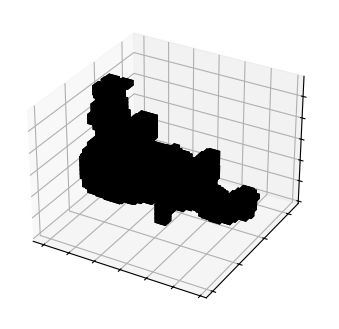

Rotation method: voxels


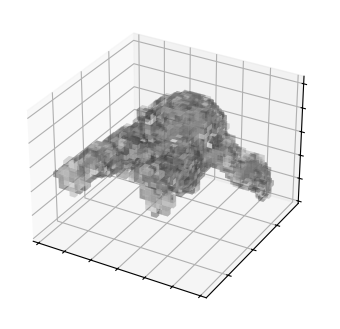

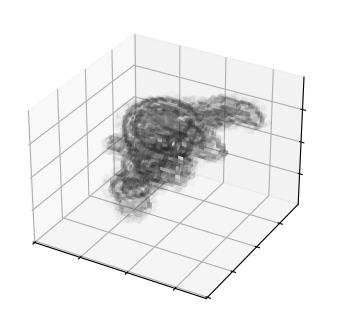

Rotation method: kde


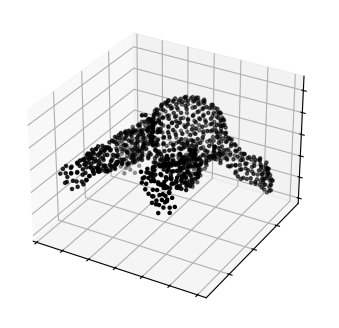

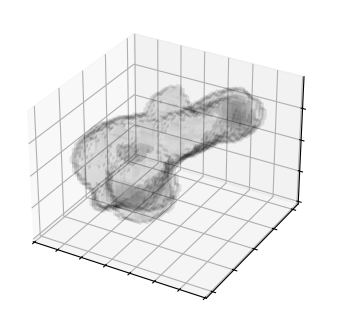

In [17]:
N_voxels = 40
x, y, z = np.linspace(-1,1,N_voxels), np.linspace(-1,1,N_voxels), np.linspace(-1,1,N_voxels)

' Illustrate rotation method: mesh '

method_data = 'mesh'
bw = .25
N_points = 1000
print('Rotation method:', method_data)

# Generate data
mesh = o3d.io.read_triangle_mesh(o3d.data.ArmadilloMesh().path)
voxel_size = 2/N_voxels
mesh.translate(-mesh.get_center())
mesh.scale(1/max(np.linalg.norm(np.array(mesh.vertices),axis=1)), mesh.get_center())
mesh = mesh.simplify_vertex_clustering(voxel_size=0.025,contraction=o3d.geometry.SimplificationContraction.Average)

# Plot rotated image
O = scipy.stats.special_ortho_group.rvs(3)
mesh.rotate(O) 
voxels_list = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh,voxel_size=voxel_size).get_voxels()
voxels_indices = np.stack(list(vx.grid_index for vx in voxels_list))
img_rot = np.zeros((N_voxels,N_voxels,N_voxels))
img_rot[voxels_indices[:, 0], voxels_indices[:, 1], voxels_indices[:, 2]] = 1
fig = plt.figure(figsize=(4,4)); ax = fig.add_subplot(projection='3d')
ax.voxels(img_rot>0.1, color='black');
ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([]);
fig.savefig('Figures/rotation_method_'+method_data+'_rotated.png',dpi=fig.dpi,bbox_inches='tight');
plt.show()

' Illustrate rotation method: voxels '

method_data = 'voxels'
N_points = 10000
print('Rotation method:', method_data)

# Generate data
mesh = o3d.io.read_triangle_mesh(o3d.data.ArmadilloMesh().path)
points = np.array(mesh.sample_points_poisson_disk(N_points).points)
mb = miniball.get_bounding_ball(points)
points -= mb[0]
points /= np.sqrt(mb[1])

# Plot initial image
img = Cloud2Voxels(points,x,y,z)
colors = np.zeros((N_voxels,N_voxels,N_voxels,4))
for i in range(4): colors[:,:,:,i] = np.abs(img/np.max(img))
fig = plt.figure(figsize=(4,4)); ax = fig.add_subplot(projection='3d')
ax.voxels(img>0.1, facecolors=colors, shade=False);
ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([]);
fig.savefig('Figures/rotation_method_'+method_data+'_initial.png',dpi=fig.dpi,bbox_inches='tight');
plt.show()

# Plot rotated image
angle01, angle02, angle12 = np.random.rand(3)*360
img_rot = scipy.ndimage.rotate(img,     angle01, axes=(0, 1), reshape=False)
img_rot = scipy.ndimage.rotate(img_rot, angle02, axes=(0, 2), reshape=False)
img_rot = scipy.ndimage.rotate(img_rot, angle12, axes=(1, 2), reshape=False)        
colors = np.zeros((N_voxels,N_voxels,N_voxels,4))
for i in range(4): colors[:,:,:,i] = np.abs(img_rot/np.max(img_rot))
fig = plt.figure(figsize=(4,4)); ax = fig.add_subplot(projection='3d')
ax.voxels(img_rot>0.1, facecolors=colors, shade=False);
ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([]);
fig.savefig('Figures/rotation_method_'+method_data+'_rotated.png',dpi=fig.dpi,bbox_inches='tight');
plt.show()

' Illustrate rotation method: kde '

method_data = 'kde'
bw = .25
N_points = 1000
print('Rotation method:', method_data)

# Generate data
mesh = o3d.io.read_triangle_mesh(o3d.data.ArmadilloMesh().path)
points = np.array(mesh.sample_points_poisson_disk(N_points).points)
mb = miniball.get_bounding_ball(points)
points -= mb[0]
points /= np.sqrt(mb[1])

# Plot initial image
fig = plt.figure(figsize=(4,4)); ax = fig.add_subplot(projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2], c='black', s=5); 
ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([]);
fig.savefig('Figures/rotation_method_'+method_data+'_initial.png',dpi=fig.dpi,bbox_inches='tight');
plt.show()

 # Plot rotated image
space = [x,y,z]
grid = np.meshgrid(*space)
coords = np.vstack(list(map(np.ravel, grid)))
O = scipy.stats.special_ortho_group.rvs(3)
points_orth = np.array([O.dot(point) for point in points])
points_orth_list = [p for p in points_orth.T]
kde = scipy.stats.gaussian_kde(points_orth_list, bw_method=bw)
img_rot = kde(coords)
kde_img = img_rot.reshape((N_voxels,N_voxels,N_voxels))
colors = np.zeros((N_voxels,N_voxels,N_voxels,4))
for i in range(4): colors[:,:,:,i] = kde_img/np.max(kde_img)
fig = plt.figure(figsize=(4,4)); ax = fig.add_subplot(projection='3d')
ax.voxels(kde_img>0.1, facecolors=colors)
ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([]);
fig.savefig('Figures/rotation_method_'+method_data+'_rotated.png',dpi=fig.dpi,bbox_inches='tight');
plt.show()

### II.1.2. Orbit detection with 'mesh' method

Compute voxel data... It 5000/5000. Duration 0:00:43 Expected remaining time 0:00:00.
Count (min/max): 494.0 560.0
Count ticks (min/max): 494 560
Covariance eigenvalues: [0.207, 0.2, 0.177, 0.089, 0.086, 0.084, 0.079, 0.077]


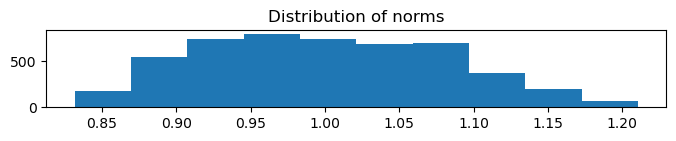

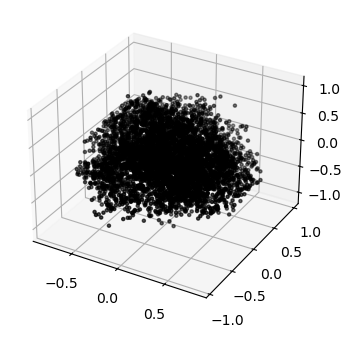

In [18]:
' Generate dataset '

name = 'armadillo'
method_data = 'mesh'
N_img = 5000
N_voxels = 20

X = MakeDatasetFromMesh(name=name,method_data=method_data,N_img=N_img,N_points=None,N_voxels=N_voxels,plot=False)

' Dimension reduction '

# Project in lower dimension via PCA and show eigenvalues
dim_pca = 8
Y = sklearn.decomposition.PCA(n_components=dim_pca).fit_transform(X)
PrintCovarianceEigenvalues(Y)

# Center and normalize
Y -= np.mean(Y,0)
Y = np.array([p/np.linalg.norm(p) for p in Y])
Y, Cov = Orthonormalize(Y)
PlotNormsDistribution(Y)

# Plot point cloud
fig = plt.figure(figsize=(4,4)); ax = fig.add_subplot(projection='3d')
Ypca = sklearn.decomposition.PCA(n_components=3).fit_transform(Y)
ax.scatter(Ypca[:,0], Ypca[:,1], Ypca[:,2], c='black', s=5);
plt.show()

----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [0.04487342274214014, 0.04670424105439676, 0.04708845918124291, 0.05787495645962822]
Eigengap #3: 1.2290688093417586


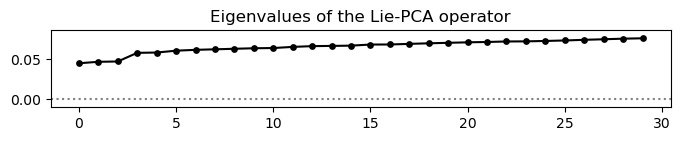

Eigengap is 1.2290688093417586


In [19]:
' LiePCA '

n_neighbors = 10
dim_LiePCA = 3
Sigma = GetLiePCAOperator(Y,n_neighbors,dim_LiePCA,method='localPCA',verbose=True)

# Plot Lie-PCA operator
vals = np.sort(np.real(np.linalg.eig(Sigma)[0]))[0:30]
fig = plt.figure(figsize=(8,1)); ax = fig.add_subplot()
ax.plot(range(len(vals)),vals,c='black'); ax.scatter(range(len(vals)), vals,c='black', s=15); 
ax.axhline(0,color='grey',linestyle='dotted'); 
ax.set_ylim((0-0.01,max(vals)+0.01)); ax.set_title('Eigenvalues of the Lie-PCA operator');
plt.show()

print('Eigengap is', vals[3]/vals[2])

First eigenvalues: [0.09045906 0.09486006 0.09566241 0.12902243]


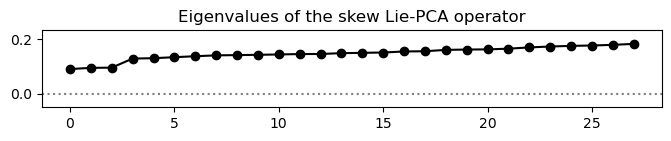

In [20]:
ambient_dim = dim_pca

dim_so = int(ambient_dim*(ambient_dim-1)/2)
SigmaSkew = np.zeros((dim_so,dim_so))
for i in range(dim_so):
    c = np.zeros(dim_so)
    c[i] = 1
    A = VectorToSkewSymmetric(c)
    A = SkewSymmetricToVector((Sigma@(A.reshape(-1))).reshape(ambient_dim,ambient_dim))
    SigmaSkew[:,i] = A
SigmaSkew = (SigmaSkew+SigmaSkew.T)

# Plot Lie-PCA operator
vals, vecs = np.linalg.eig(SigmaSkew); vals = np.sort(np.real(vals))
    #find eigenvalues and vectors of sigma as a matrix
fig = plt.figure(figsize=(8,1)); ax = fig.add_subplot()
ax.plot(range(len(vals)),vals,c='black'); ax.scatter(range(len(vals)), vals,c='black'); 
ax.axhline(0,color='grey',linestyle='dotted'); 
ax.set_ylim((0-0.05,max(vals)+0.05)); ax.set_title('Eigenvalues of the skew Lie-PCA operator');
print('First eigenvalues:', vals[0:4])

In [21]:
def SkewSymmetricToVector(A):
    '''
    Given a skew-symmetric matrix written in the canonical basis of M_n(R),
    writes it in the canonical basis of S_n(R)
    
    Example:
        A = np.array([[0,1,2],[-1,0,1], [-2,-1,0]]); print(A)
        >>> [[ 0  1  2]
             [-1  0  1]
             [-2 -1  0]] 
        v = SkewSymmetricToVector(A); print(v)
        >>> [1 2 1]
    '''
    d = np.shape(A)[0]
    
    # Skew-symmetrize the matrix, in case it is not skew-symmetric already
    A = (A-A.T)/2

    # Create the indices of the canonical basis of S_n(R)
    Indices = [tuple([i,j]) for i in range(d) for j in range(i+1,d)]
    
    # Get values of the indices corresponding to the basis
    Av = np.array([A[t] for t in Indices])    
    
    return Av

def FindClosestLieAlgebraSkew(group, Sigma, dim=None, ambient_dim=4, frequency_max=3, FrequenciesToTest=None, method='Grassmann',verbosity=1,return_ChangeOfBasis=False):
    '''
    Input: 
    - group: can be 'torus', 'SU(2)' or 'SO(3)'
    - dim: dimension of the torus, if group='torus', and 3 if group='SU(2)' or 'SO(3)'
    - method: can be 'Grassmann' or 'Stiefel' or 'NormalForm' (the latter only for group='torus')
    - verbosity: 0 (no verbose), 1 (a few comments), 2 (comments from pymanopt)
    '''
    if verbosity>0: print('----> Optimization problem via'+'\x1b[1;31m', method, '\x1b[0m'+'for', group, 'group <----')

    # Get FrequenciesToTest
    if FrequenciesToTest==None:
        if group=='torus': FrequenciesToTest = GetFrequenciesToTest(dim=dim, ambient_dim=ambient_dim, frequency_max=frequency_max, verbose=verbosity)
        if group=='SU(2)': FrequenciesToTest = [tuple(f) for f in partition_su2(ambient_dim)]
        if group=='SO(3)': FrequenciesToTest = [tuple(f) for f in partition_so3(ambient_dim)]

    if method in ['Grassmann', 'NormalForm']:
        # Get and sort eigenvectors of Sigma
        vals, vecs = np.linalg.eig(Sigma) # finds eigenvalues and vectors of sigma as a matrix
        vecs = [vecs[:,i] for i in range(len(vecs))]
        indices = np.argsort(vals)        # argsort eigenvalues
        vals, vecs = [np.real(vals[i]) for i in indices], [np.real(vecs[i]) for i in indices]

        # Get bottom eigenvectors of Sigma
        LieAlgebra = [VectorToSkewSymmetric(vecs[i]) for i in range(dim)]

    if method in ['Grassmann']:
        # Define Projection0, the projection matrix on the vector subspace given by Lie PCA
        Projection0 = FrameToProjection(LieAlgebra)
        
    if method in ['Grassmann', 'Stiefel']:
        # Run optimization with pymanopt
        if verbosity>0: start_time = ChronometerStart('Solve minimization problem... ')
        Costs = dict() 
        ChangeOfBasis = dict()
        for i in range(len(FrequenciesToTest)):
            frequencies = FrequenciesToTest[i]
            Costs[frequencies] = np.inf
            for determinant in ['+1','-1']:
                if method=='Grassmann': result = OptimizationGrassmann(group, Projection0, frequencies, ambient_dim, dim, determinant, verbosity=0)    
                elif method=='Stiefel': result = OptimizationStiefel(group, Sigma, frequencies, ambient_dim, dim, determinant, verbosity=0)  
                if result.cost < Costs[frequencies]: Costs[frequencies], ChangeOfBasis[frequencies] = result.cost, result.point
                if verbosity>2: print('Frequencies', frequencies, '- det', determinant, '- result', result.cost)
                if verbosity>3: print('('+result.stopping_criterion+')')
            if verbosity>0: ChronometerTick(start_time, i, len(FrequenciesToTest), 'Solve minimization problem... ')

        # Define optimal angle and cost
        OptimalFrequencies = min(Costs.keys(), key=(lambda k: Costs[k]))
        OptimalChangeOfBasis = ChangeOfBasis[OptimalFrequencies]
            
        # Define OptimalLieAlgebra
        if group=='torus': OptimalLieAlgebra = GetCanonicalLieAlgebraTorus(OptimalFrequencies)
        if group=='SU(2)': OptimalLieAlgebra = GetCanonicalLieAlgebraSU2(OptimalFrequencies)
        OptimalLieAlgebra = [OptimalChangeOfBasis @ OptimalLieAlgebra[i] @ OptimalChangeOfBasis.T for i in range(dim)]
        OptimalLieAlgebra = GramSchmidtOrthonormalizationMatrices(OptimalLieAlgebra)
    
    elif method in ['NormalForm']:
        if dim==1:    
            # Estimate frequencies
            angles, OptimalChangeOfBasis, T = NormalFormSkewSymmetricMatrix(LieAlgebra[0])
            angles = np.sort(np.abs(angles))
            if verbosity>1: print('Normalized frequencies found in normal form decomposition:', tuple(angles))

            # Generate frequencies to test
            FrequenciesToTestNorm = [list(f[0])/np.linalg.norm(f[0]) for f in FrequenciesToTest]

            # Find closest frequencies
            Costs = {FrequenciesToTest[i]:np.linalg.norm(FrequenciesToTestNorm[i]-angles) for i in range(len(FrequenciesToTest))} 
            OptimalFrequencies = min(Costs.keys(), key=(lambda k: Costs[k]))
                                                    
            # Define Lie algebra
            L = GetCanonicalLieAlgebraTorus(OptimalFrequencies)
            OptimalLieAlgebra = [OptimalChangeOfBasis @ L[0]/np.linalg.norm(L[0]) @ OptimalChangeOfBasis.T]
            
        else: #dim >1
            # Orthonormalize 
            LieAlgebra = GramSchmidtOrthonormalizationMatrices(LieAlgebra)
            if verbosity>1: print('Test commutation:', np.linalg.norm(LieAlgebra[0] @ LieAlgebra[1] - LieAlgebra[1] @ LieAlgebra[0]))

            # Get frequencies via normal form
            frequencies, OptimalChangeOfBasis = NormalFormSkewSymmetricMatrices(LieAlgebra)
            if verbosity>1: print('Normalized frequencies found in normal form decomposition:', tuple(frequencies))
            
            # Expand GetFrequenciesToTest by permutation and negative values
            m = int(ambient_dim/2)
            indices = powerset(range(m))
            FrequenciesToTest_dic = {} #dict to remember the initial value of freq
            # 1/2: Put negative values
            FrequenciesToTest_positivenegative = []  #expanded frequencies
            for freq in FrequenciesToTest:
                freqlist = [list(f) for f in freq]
                for i in range(len(indices)):
                    freqi = copy.deepcopy(freqlist)
                    for j in indices[i]:
                        for k in range(len(freqi)): freqi[k][j] *= -1
                    freqi = tuple([tuple(f) for f in freqi])
                    FrequenciesToTest_positivenegative.append(freqi)
                    FrequenciesToTest_dic[freqi] = freq
            # 2/2: Permute tuples
            Permutations = list(itertools.permutations(range(m)))
            for freq in FrequenciesToTest_positivenegative:
                for perm in Permutations:
                    freqi = tuple([tuple([freq[i][j] for j in perm]) for i in range(len(freq))])
                    FrequenciesToTest_dic[freqi] = FrequenciesToTest_dic[freq]            
            if verbosity>1: print('There are', len(FrequenciesToTest_dic), 'expanded frequencies to test, out of',len(set(list(FrequenciesToTest_dic.values()))))
            
            # Get OptimalFrequencies
            Proj0 = np.sum([ np.outer(v,v) for v in GramSchmidtOrthonormalizationVectors(frequencies)],0)
            Costs_expanded = dict()
            for freq in FrequenciesToTest_dic:
                Proj = np.sum([ np.outer(v,v) for v in GramSchmidtOrthonormalizationVectors(freq)],0)
                Costs_expanded[freq] = np.linalg.norm(Proj-Proj0)
            Costs_original = {freq:np.inf for freq in FrequenciesToTest}
            FrequenciesToTest_dic_inv = {}
            for freq_new in FrequenciesToTest_dic:
                freq = FrequenciesToTest_dic[freq_new]
                if Costs_expanded[freq_new]<Costs_original[freq]:
                    Costs_original[freq] = Costs_expanded[freq_new]
                    FrequenciesToTest_dic_inv[freq] = freq_new
            Costs = {FrequenciesToTest_dic_inv[freq]:Costs_original[freq] for freq in FrequenciesToTest_dic_inv}            
            OptimalFrequencies = min(Costs.keys(), key=(lambda k: Costs[k]))
                                  
            # Define OptimalLieAlgebra
            OptimalLieAlgebra = GetCanonicalLieAlgebraTorus(OptimalFrequencies)
            OptimalLieAlgebra = [OptimalChangeOfBasis.T @ A @ OptimalChangeOfBasis for A in OptimalLieAlgebra]

    # Print comments
    if verbosity>0: print('\x1b[1;31m'+'The optimal frequencies found is '+repr(OptimalFrequencies)+'\x1b[0m'+' with cost '+repr(Costs[OptimalFrequencies]))
    if verbosity>1: # print best twelve costs
        scores = [Costs[freq] for freq in Costs]
        indices = np.argsort(scores)
        for i in range(min(len(indices),12)): print('Frequencies', FrequenciesToTest[indices[i]], '- score', round(scores[indices[i]],5), '(best cost #'+repr(i+1)+'/'+repr(len(FrequenciesToTest))+')')
        
    if return_ChangeOfBasis:
        return OptimalFrequencies, OptimalLieAlgebra, OptimalChangeOfBasis
    else:
        return OptimalFrequencies, OptimalLieAlgebra

----> Optimization problem via Grassmann for SU(2) group <----
Solve minimization problem... It 1/1. Duration 0:02:12 Expected remaining time 0:00:00.
The optimal frequencies found is (3, 5) with cost 0.19471824470078547
Non-symmetric Hausdorff distance from point cloud to estimated orbit: 1.0756698907010067 
Non-symmetric Hausdorff distance from estimated orbit to point cloud: 0.6575272626448098


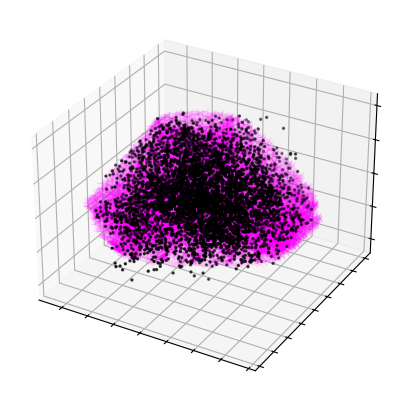

In [22]:
' LieDetect '

group, dim = 'SU(2)', 3
ambient_dim = dim_pca
FrequenciesToTest = [(3, 5)]
method_optim = 'Grassmann'
OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebraSkew(group,SigmaSkew,dim,ambient_dim,FrequenciesToTest=FrequenciesToTest,
                                                              method=method_optim,verbosity=1)

' Generate orbit and plot '

# Generate estimated orbit
n_points_orbit = 30
x = Y[0,:] #initial point of X
Orbit = GenerateOrbitSU2(OptimalLieAlgebra, OptimalFrequencies, n_points=n_points_orbit, x=x)

# Compute non-symmetric Hausdorff
Hausdorff = scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0]
print('\x1b[1;31m'+'Non-symmetric Hausdorff distance from point cloud to estimated orbit:', Hausdorff,'\x1b[0m')
Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, Y)[0]
print('Non-symmetric Hausdorff distance from estimated orbit to point cloud:', Hausdorff)

# Plot orbit
pca = sklearn.decomposition.PCA(n_components=3)
Ypca = pca.fit_transform(Y)
fig = plt.figure(figsize=(5,5)); ax = fig.add_subplot(projection='3d')
ax.scatter(Ypca[:,0], Ypca[:,1], Ypca[:,2], c='black', s=2);
Orbitpca = pca.transform(Orbit)
ax.plot(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=0.5, alpha=0.1,marker="3");
ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([]);
fig.savefig('Figures/armadillo_orbit_'+method_data+'.png',dpi=fig.dpi,bbox_inches='tight');

----> Optimization problem via Stiefel for SU(2) group <----
Solve minimization problem... It 1/1. Duration 0:01:40 Expected remaining time 0:00:00.
The optimal frequencies found is (3, 5) with cost 0.0069508814063394125
Non-symmetric Hausdorff distance from point cloud to estimated orbit: 1.1067190954063746 
Non-symmetric Hausdorff distance from estimated orbit to point cloud: 0.6466831806409273


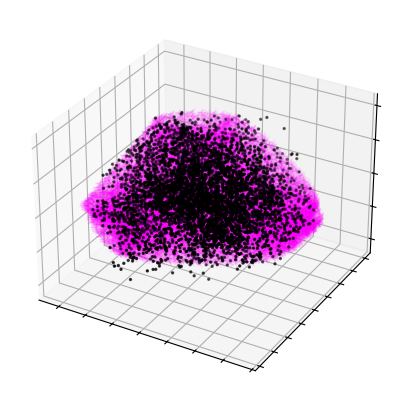

In [23]:
' LieDetect '

group, dim = 'SU(2)', 3
ambient_dim = dim_pca
FrequenciesToTest = [(3, 5)]
method_optim = 'Stiefel'
OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra(group,Sigma,dim,ambient_dim,FrequenciesToTest=FrequenciesToTest,
                                                              method=method_optim,verbosity=1)

' Generate orbit and plot '

# Generate estimated orbit
n_points_orbit = 30
x = Y[0,:] #initial point of X
Orbit = GenerateOrbitSU2(OptimalLieAlgebra, OptimalFrequencies, n_points=n_points_orbit, x=x)

# Compute non-symmetric Hausdorff
Hausdorff = scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0]
print('\x1b[1;31m'+'Non-symmetric Hausdorff distance from point cloud to estimated orbit:', Hausdorff,'\x1b[0m')
Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, Y)[0]
print('Non-symmetric Hausdorff distance from estimated orbit to point cloud:', Hausdorff)

# Plot orbit
pca = sklearn.decomposition.PCA(n_components=3)
Ypca = pca.fit_transform(Y)
fig = plt.figure(figsize=(5,5)); ax = fig.add_subplot(projection='3d')
ax.scatter(Ypca[:,0], Ypca[:,1], Ypca[:,2], c='black', s=2);
Orbitpca = pca.transform(Orbit)
ax.plot(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=0.5, alpha=0.1,marker="3");
ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([]);
fig.savefig('Figures/armadillo_orbit_'+method_data+'.png',dpi=fig.dpi,bbox_inches='tight');

### II.1.3. Orbit detection with 'voxels' method

Compute voxel data... It 5000/5000. Duration 0:00:20 Expected remaining time 0:00:00.
Count (min/max): 969.6129228120853 1002.9748922390522
Count ticks (min/max): 3321 4513
Covariance eigenvalues: [0.217, 0.156, 0.152, 0.103, 0.1, 0.099, 0.089, 0.085]


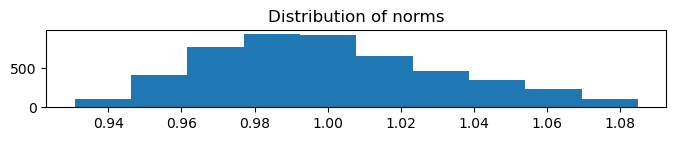

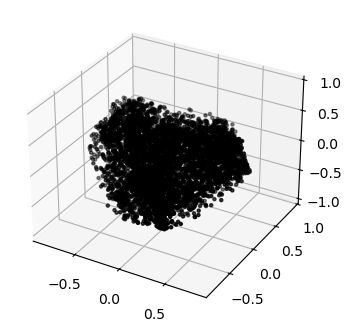

In [24]:
' Generate dataset '

name = 'armadillo'
method_data = 'voxels'
N_img = 5000
N_voxels = 20
N_points = 1000

X = MakeDatasetFromMesh(name=name,method_data=method_data,N_img=N_img,N_points=N_points,N_voxels=N_voxels,plot=False)

' Dimension reduction '

# Project in lower dimension via PCA and show eigenvalues
dim_pca = 8
Y = sklearn.decomposition.PCA(n_components=dim_pca).fit_transform(X)
PrintCovarianceEigenvalues(Y)

# Center and normalize
Y -= np.mean(Y,0)
Y = np.array([p/np.linalg.norm(p) for p in Y])
Y, Cov = Orthonormalize(Y)
PlotNormsDistribution(Y)

# Plot point cloud
fig = plt.figure(figsize=(4,4)); ax = fig.add_subplot(projection='3d')
Ypca = sklearn.decomposition.PCA(n_components=3).fit_transform(Y)
ax.scatter(Ypca[:,0], Ypca[:,1], Ypca[:,2], c='black', s=5);
plt.show()

----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [0.004202296055905048, 0.00701900275407308, 0.007191149012735603, 0.048857455180555745]
Eigengap #3: 6.7941096887338395


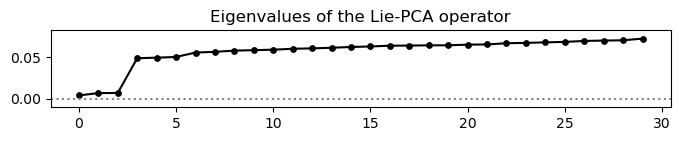

Eigengap is 6.7941096887338395


In [25]:
' LiePCA '

n_neighbors = 10
dim_LiePCA = 3
Sigma = GetLiePCAOperator(Y,n_neighbors,dim_LiePCA,method='localPCA',verbose=True)

# Plot Lie-PCA operator
vals = np.sort(np.real(np.linalg.eig(Sigma)[0]))[0:30]
fig = plt.figure(figsize=(8,1)); ax = fig.add_subplot()
ax.plot(range(len(vals)),vals,c='black'); ax.scatter(range(len(vals)), vals,c='black', s=15); 
ax.axhline(0,color='grey',linestyle='dotted'); 
ax.set_ylim((0-0.01,max(vals)+0.01)); ax.set_title('Eigenvalues of the Lie-PCA operator');
plt.show()

print('Eigengap is', vals[3]/vals[2])

----> Optimization problem via Stiefel for SU(2) group <----
Solve minimization problem... It 1/1. Duration 0:01:45 Expected remaining time 0:00:00.
The optimal frequencies found is (3, 5) with cost 0.0002250129882241301
Non-symmetric Hausdorff distance from point cloud to estimated orbit: 0.3940511693754685 
Non-symmetric Hausdorff distance from estimated orbit to point cloud: 0.5034475886306908


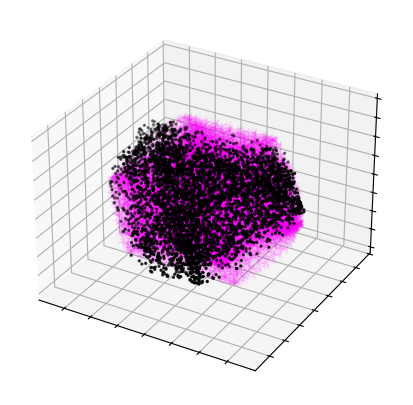

In [26]:
' LieDetect '

group, dim = 'SU(2)', 3
ambient_dim = dim_pca
# FrequenciesToTest = None
FrequenciesToTest = [(3, 5)]
method_optim = 'Stiefel'
OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra(group,Sigma,dim,ambient_dim,FrequenciesToTest=FrequenciesToTest,
                                                              method=method_optim,verbosity=1)

' Generate orbit and plot '

# Generate estimated orbit
n_points_orbit = 30
x = Y[0,:] #initial point of X
Orbit = GenerateOrbitSU2(OptimalLieAlgebra, OptimalFrequencies, n_points=n_points_orbit, x=x)

# Compute non-symmetric Hausdorff
Hausdorff = scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0]
print('\x1b[1;31m'+'Non-symmetric Hausdorff distance from point cloud to estimated orbit:', Hausdorff,'\x1b[0m')
Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, Y)[0]
print('Non-symmetric Hausdorff distance from estimated orbit to point cloud:', Hausdorff)

# Plot orbit
pca = sklearn.decomposition.PCA(n_components=3)
Ypca = pca.fit_transform(Y)
fig = plt.figure(figsize=(5,5)); ax = fig.add_subplot(projection='3d')
ax.scatter(Ypca[:,0], Ypca[:,1], Ypca[:,2], c='black', s=2);
Orbitpca = pca.transform(Orbit)
ax.plot(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=0.5, alpha=0.1,marker="3");
ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([]);
fig.savefig('Figures/armadillo_orbit_'+method_data+'.png',dpi=fig.dpi,bbox_inches='tight');

### II.1.4. Orbit detection with 'kde' method

Compute voxel data... It 5000/5000. Duration 0:08:22 Expected remaining time 0:00:00.
Count (min/max): 847.1820807558835 857.2951761774459
Count ticks (min/max): 8000 8000
Covariance eigenvalues: [0.246, 0.239, 0.234, 0.058, 0.057, 0.056, 0.055, 0.054]


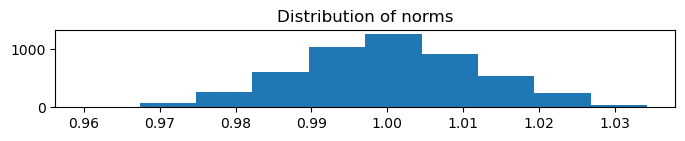

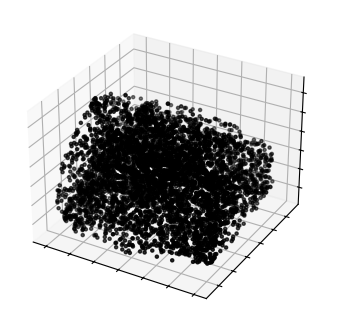

In [27]:
' Generate dataset '

name = 'armadillo'
method_data = 'kde'
N_img = 5000
N_voxels = 20
N_points = 1000
bw = .25

X = MakeDatasetFromMesh(name=name,method_data=method_data,N_img=N_img,N_voxels=N_voxels,N_points=N_points,bw=bw,plot=False)

' Dimension reduction '

# Project in lower dimension via PCA and show eigenvalues
dim_pca = 8
Y = sklearn.decomposition.PCA(n_components=dim_pca).fit_transform(X)
PrintCovarianceEigenvalues(Y)

# Center and normalize
Y -= np.mean(Y,0)
Y = np.array([p/np.linalg.norm(p) for p in Y])
Y, Cov = Orthonormalize(Y)
PlotNormsDistribution(Y)

# Plot point cloud
fig = plt.figure(figsize=(4,4)); ax = fig.add_subplot(projection='3d')
Ypca = sklearn.decomposition.PCA(n_components=3).fit_transform(Y)
ax.scatter(Ypca[:,0], Ypca[:,1], Ypca[:,2], c='black', s=5);
ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([]);
plt.show()

----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [0.0032463356350525066, 0.0032863183961747127, 0.0033908550372233476, 0.05299385140701121]
Eigengap #3: 15.628462681320054


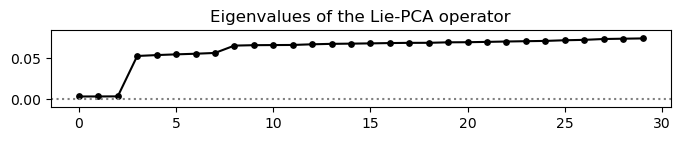

Eigengap is 15.628462681320054


In [28]:
' LiePCA '

n_neighbors = 10
dim_LiePCA = 3
Sigma = GetLiePCAOperator(Y,n_neighbors,dim_LiePCA,method='localPCA',verbose=True)

# Plot Lie-PCA operator
vals = np.sort(np.real(np.linalg.eig(Sigma)[0]))[0:30]
fig = plt.figure(figsize=(8,1)); ax = fig.add_subplot()
ax.plot(range(len(vals)),vals,c='black'); ax.scatter(range(len(vals)), vals,c='black', s=15); 
ax.axhline(0,color='grey',linestyle='dotted'); 
ax.set_ylim((0-0.01,max(vals)+0.01)); ax.set_title('Eigenvalues of the Lie-PCA operator');
plt.show()

print('Eigengap is', vals[3]/vals[2])

----> Optimization problem via Stiefel for SU(2) group <----
Solve minimization problem... It 1/1. Duration 0:01:27 Expected remaining time 0:00:00.
The optimal frequencies found is (3, 5) with cost 5.181262421335549e-05
Non-symmetric Hausdorff distance from point cloud to estimated orbit: 0.1630379952085877 
Non-symmetric Hausdorff distance from estimated orbit to point cloud: 0.347883475296957


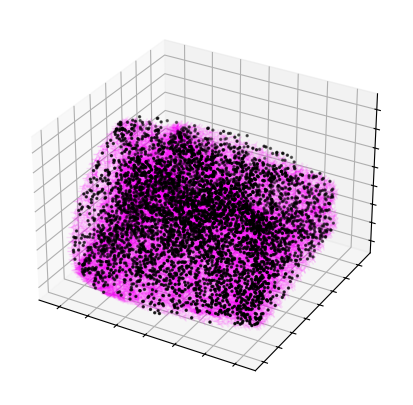

In [29]:
' LieDetect '

group, dim = 'SU(2)', 3
ambient_dim = dim_pca
FrequenciesToTest = [(3, 5)]
method_optim = 'Stiefel'
OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra(group,Sigma,dim,ambient_dim,FrequenciesToTest=FrequenciesToTest,
                                                              method=method_optim,verbosity=1)

' Generate orbit and plot '

# Generate estimated orbit
n_points_orbit = 30
x = Y[0,:] #initial point of X
Orbit = GenerateOrbitSU2(OptimalLieAlgebra, OptimalFrequencies, n_points=n_points_orbit, x=x)

# Compute non-symmetric Hausdorff
Hausdorff = scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0]
print('\x1b[1;31m'+'Non-symmetric Hausdorff distance from point cloud to estimated orbit:', Hausdorff,'\x1b[0m')
Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, Y)[0]
print('Non-symmetric Hausdorff distance from estimated orbit to point cloud:', Hausdorff)

# Plot orbit
pca = sklearn.decomposition.PCA(n_components=3)
Ypca = pca.fit_transform(Y)
fig = plt.figure(figsize=(5,5)); ax = fig.add_subplot(projection='3d')
ax.scatter(Ypca[:,0], Ypca[:,1], Ypca[:,2], c='black', s=2);
Orbitpca = pca.transform(Orbit)
ax.plot(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=0.5, alpha=0.1,marker="3");
ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([]);
fig.savefig('Figures/armadillo_orbit_'+method_data+'.png',dpi=fig.dpi,bbox_inches='tight');

## II.2. Detection of eigengaps

Compute voxel data... It 5000/5000. Duration 0:00:50 Expected remaining time 0:00:00.
Count (min/max): 488.0 559.0
Count ticks (min/max): 488 559


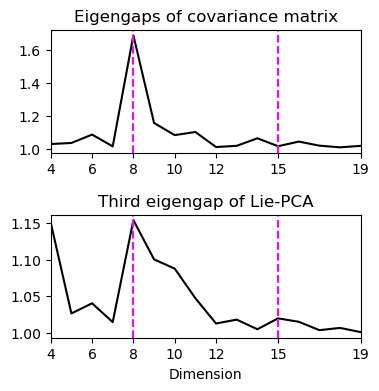

In [30]:
' Generate dataset with method mesh '

name = 'armadillo'
method_data = 'mesh'
N_img = 5000
N_voxels = 20

X = MakeDatasetFromMesh(name=name,method_data=method_data,N_img=N_img,N_voxels=N_voxels,plot=False)

' Identify eigengaps '

# Compute eigengaps in covariance matrix
S = np.mean([np.outer(X[i,:],X[i,:]) for i in range(np.shape(X)[0])],0)
eigenvalues = np.flip(sorted(np.linalg.eig(S)[0]))
eigengaps = [eigenvalues[i]/eigenvalues[i+1] for i in range(0,19)]

# Compute eigengaps in LiePCA
eigengaps_LiePCA = []
for dim_pca in range(4,20):
    Y = sklearn.decomposition.PCA(n_components=dim_pca).fit_transform(X)
    n_neighbors, dim_LiePCA = 10, 3
    Sigma = GetLiePCAOperator(Y,n_neighbors,dim_LiePCA,method='localPCA',verbose=False)    
    vals = np.sort(np.real(np.linalg.eig(Sigma)[0]))[0:30]
    eigengaps_LiePCA.append(vals[3]/vals[2])

# Plot
fig, axs = plt.subplots(2,1,figsize=(4,4)); 
plt.subplots_adjust(wspace=0, hspace=0.5)
axs[0].plot(range(4,20), eigengaps[3:20], c='black')
axs[1].plot(range(4,20), eigengaps_LiePCA, c='black')
axs[0].set_title('Eigengaps of covariance matrix', fontsize=12)
axs[1].set_title('Third eigengap of Lie-PCA', fontsize=12)
axs[1].set_xlabel('Dimension', fontsize=10)
for ax in axs: 
    ax.set_xticks([4,6,8,10,12,15,19]);
    ax.axvline(8, color='magenta',ls='dashed')
    ax.axvline(15, color='magenta',ls='dashed')
    ax.set_xlim(4,19)
fig.savefig('Figures/armadillo_eigengaps_'+method_data+'.png',dpi=fig.dpi,bbox_inches='tight');

Compute voxel data... It 5000/5000. Duration 0:00:20 Expected remaining time 0:00:00.
Count (min/max): 974.9246415900407 1003.9264543344743
Count ticks (min/max): 3298 4466


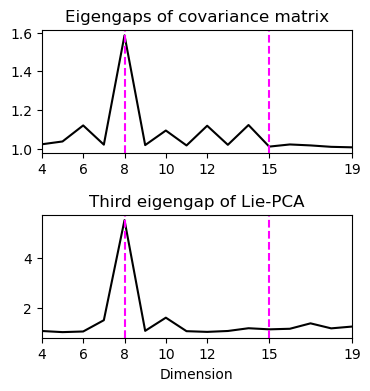

In [31]:
' Generate dataset with method voxels '

name = 'armadillo'
method_data = 'voxels'
N_img = 5000
N_voxels = 20
N_points = 1000

X = MakeDatasetFromMesh(name=name,method_data=method_data,N_img=N_img,N_points=N_points,N_voxels=N_voxels,plot=False)

' Identify eigengaps '

# Compute eigengaps in covariance matrix
S = np.mean([np.outer(X[i,:],X[i,:]) for i in range(np.shape(X)[0])],0)
eigenvalues = np.flip(sorted(np.linalg.eig(S)[0]))
eigengaps = [eigenvalues[i]/eigenvalues[i+1] for i in range(0,19)]

# Compute eigengaps in LiePCA
eigengaps_LiePCA = []
for dim_pca in range(4,20):
    Y = sklearn.decomposition.PCA(n_components=dim_pca).fit_transform(X)
    n_neighbors, dim_LiePCA = 10, 3
    Sigma = GetLiePCAOperator(Y,n_neighbors,dim_LiePCA,method='localPCA',verbose=False)    
    vals = np.sort(np.real(np.linalg.eig(Sigma)[0]))[0:30]
    eigengaps_LiePCA.append(vals[3]/vals[2])

# Plot
fig, axs = plt.subplots(2,1,figsize=(4,4)); 
plt.subplots_adjust(wspace=0, hspace=0.5)
axs[0].plot(range(4,20), eigengaps[3:20], c='black')
axs[1].plot(range(4,20), eigengaps_LiePCA, c='black')
axs[0].set_title('Eigengaps of covariance matrix', fontsize=12)
axs[1].set_title('Third eigengap of Lie-PCA', fontsize=12)
axs[1].set_xlabel('Dimension', fontsize=10)
for ax in axs: 
    ax.set_xticks([4,6,8,10,12,15,19]);
    ax.axvline(8, color='magenta',ls='dashed')
    ax.axvline(15, color='magenta',ls='dashed')
    ax.set_xlim(4,19)
fig.savefig('Figures/armadillo_eigengaps_'+method_data+'.png',dpi=fig.dpi,bbox_inches='tight');

Compute voxel data... It 5000/5000. Duration 0:08:09 Expected remaining time 0:00:00.
Count (min/max): 846.9989718439177 857.3383928979471
Count ticks (min/max): 8000 8000


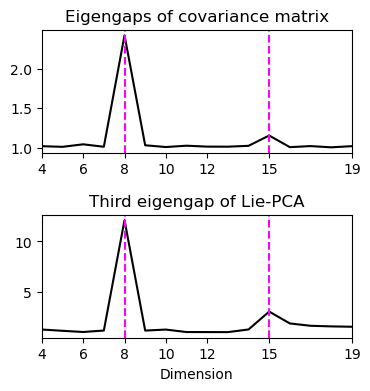

In [32]:
' Generate dataset with method kde '

name = 'armadillo'
method_data = 'kde'
N_img = 5000
N_voxels = 20
N_points = 1000
bw = .25

X = MakeDatasetFromMesh(name=name,method_data=method_data,N_img=N_img,N_voxels=N_voxels,N_points=N_points,bw=bw,plot=False)

' Identify eigengaps '

# Compute eigengaps in covariance matrix
S = np.mean([np.outer(X[i,:],X[i,:]) for i in range(np.shape(X)[0])],0)
eigenvalues = np.flip(sorted(np.linalg.eig(S)[0]))
eigengaps = [eigenvalues[i]/eigenvalues[i+1] for i in range(0,19)]

# Compute eigengaps in LiePCA
eigengaps_LiePCA = []
for dim_pca in range(4,20):
    Y = sklearn.decomposition.PCA(n_components=dim_pca).fit_transform(X)
    n_neighbors, dim_LiePCA = 10, 3
    Sigma = GetLiePCAOperator(Y,n_neighbors,dim_LiePCA,method='localPCA',verbose=False)    
    vals = np.sort(np.real(np.linalg.eig(Sigma)[0]))[0:30]
    eigengaps_LiePCA.append(vals[3]/vals[2])

# Plot
fig, axs = plt.subplots(2,1,figsize=(4,4)); 
plt.subplots_adjust(wspace=0, hspace=0.5)
axs[0].plot(range(4,20), eigengaps[3:20], c='black')
axs[1].plot(range(4,20), eigengaps_LiePCA, c='black')
axs[0].set_title('Eigengaps of covariance matrix', fontsize=12)
axs[1].set_title('Third eigengap of Lie-PCA', fontsize=12)
axs[1].set_xlabel('Dimension', fontsize=10)
for ax in axs: 
    ax.set_xticks([4,6,8,10,12,15,19]);
    ax.axvline(8, color='magenta',ls='dashed')
    ax.axvline(15, color='magenta',ls='dashed')
    ax.set_xlim(4,19)
fig.savefig('Figures/armadillo_eigengaps_'+method_data+'.png',dpi=fig.dpi,bbox_inches='tight');

## II.3. $\mathrm{SO(3)}$-action on armadillo in $\mathbb{R}^{15}$

In [34]:
' Generate dataset with method kde '

name = 'armadillo'
method_data = 'kde'
N_img = 5000
N_voxels = 20
N_points = 1000
bw = .25

X = MakeDatasetFromMesh(name=name,method_data=method_data,N_img=N_img,N_voxels=N_voxels,N_points=N_points,bw=bw,plot=False)

' LieDetect in dimension 15 '

# Dimension reduction '
dim_pca = 15
Y = sklearn.decomposition.PCA(n_components=dim_pca).fit_transform(X)
Y, _ = Orthonormalize(Y)

# Lie-PCA 
n_neighbors = 50
dim_LiePCA = 3
Sigma = GetLiePCAOperator(Y,n_neighbors,dim_LiePCA,method='localPCA',verbose=True)

# Plot Lie-PCA operator
vals = np.sort(np.real(np.linalg.eig(Sigma)[0]))[0:30]
fig = plt.figure(figsize=(8,1)); ax = fig.add_subplot()
ax.plot(range(len(vals)),vals,c='black'); ax.scatter(range(len(vals)), vals,c='black', s=15); 
ax.axhline(0,color='grey',linestyle='dotted'); 
ax.set_ylim((0-0.01,max(vals)+0.01)); ax.set_title('Eigenvalues of the Lie-PCA operator');
plt.show()

# LieDetect
group, dim = 'SU(2)', 3
ambient_dim = dim_pca
FrequenciesToTest = [tuple(freq) for freq in partition_su2(ambient_dim) if 1 not in freq]
method_optim = 'Stiefel'
OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra(group,Sigma,dim,ambient_dim,FrequenciesToTest=FrequenciesToTest,
                                                              method=method_optim,verbosity=1)

# Generate orbit and plot
n_points_orbit = 30
x = Y[0,:] # arbitrary initial point
Orbit = GenerateOrbitSU2(OptimalLieAlgebra, OptimalFrequencies, n_points=n_points_orbit, x=x)
pca = sklearn.decomposition.PCA(n_components=3)
Ypca = pca.fit_transform(Y)
fig = plt.figure(figsize=(5,5)); ax = fig.add_subplot(projection='3d')
ax.scatter(Ypca[:,0], Ypca[:,1], Ypca[:,2], c='black', s=2);
Orbitpca = pca.transform(Orbit)
ax.plot(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=0.5, alpha=0.1,marker="3");
plt.show();
fig.savefig('Figures/armadillo_kde_orbit_dim15.png',dpi=fig.dpi,bbox_inches='tight');

# Compute non-symmetric Hausdorff
Hausdorff = scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0]
print('\x1b[1;31m'+'Non-symmetric Hausdorff distance from point cloud to estimated orbit:', Hausdorff,'\x1b[0m')
Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, Y)[0]
print('Non-symmetric Hausdorff distance from estimated orbit to point cloud:', Hausdorff)

# III. Harmonic analysis

## III.1. Translated gorillas with gaussian filter

In [35]:
def feedforward(number_of_layers, neurons_per_hidden_layer, activation, inputs_shape = 4):
    '''
    This function creates a simple feedforward neural network
    Input: number_of_layers: number of hidden layers in the network; neurons_per_hidden_layer: width of each hidden layer, which must be the
    same for all layers; activation: activation function for each hidden layer, which must be the same; inputs_shape = 3: shape of input
    set to 3 by default
    Output model of the neural network
    '''
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(inputs_shape,)))
    for i in range(number_of_layers):
        model.add(tf.keras.layers.Dense(neurons_per_hidden_layer, activation=activation))
    model.add(tf.keras.layers.Dense(1, activation='relu'))
    return model

def trains_network(model, number_of_epochs, data, target, verbose = 2, plot = False):
    '''
    Splits the dataset into train and validation and trains neurak network
    Input: model: the neural network to be trained; number_of_epochs: number of training epochs; data: dataset; target: dataset's labels;
    verbose = 2: verbose in training history;
    plot == False: if True, plots the training history
    '''
    X_train, X_val, y_train, y_val = train_test_split(data, target, test_size = 0.1, random_state = 42)
    
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 100)
    model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mean_squared_error'])
    history = model.fit(X_train, y_train, epochs = number_of_epochs, validation_data = (X_val, y_val), batch_size=32, callbacks=[callback],
                        verbose = verbose)
    model.evaluate(data, target)
    
    if plot == True:
        plt.plot(history.history['val_loss'])
    return 
    
def func_2D(beta, i, j, max_freq_fourrier, l, N_1, N_2):
    '''
    Defines a regressor for a 2D regression problem
    '''
    val = sum([beta[l.index(str(n) + ' ' + str(m))]*np.exp(2*np.pi*n*1j*i/N_1)*np.exp(2*np.pi*m*1j*j/N_2) 
               for n in range(-max_freq_fourrier, max_freq_fourrier + 1) 
               for m in range(-max_freq_fourrier, max_freq_fourrier + 1)])[0]
    return val

def regression(X, y, N_1 = 65, N_2 = 60, max_freq_fourrier = 10):
    '''
    Performs the regression itself using the harmonic analysis decomposition
    '''
    N = X.shape[0]
    shape_transforms =  (N, (2*max_freq_fourrier + 1)**2)
    transform = np.ones(shape_transforms, dtype=np.complex_)
    for i in range(N):
        transform[i] =  np.array([np.exp(2*np.pi*n*1j*X[i][0]/N_1)*np.exp(2*np.pi*m*1j*X[i][1]/N_2) for n in range(-max_freq_fourrier, max_freq_fourrier + 1) for m in range(-max_freq_fourrier, max_freq_fourrier + 1)])
    transform_conj = transform.conjugate().T
    betas = np.linalg.pinv(transform_conj@transform)@transform_conj@y.reshape(N, 1)
    
    return betas

def predict(X, betas, N_1 = 65, N_2 = 60, max_freq_fourrier = 10):
    '''
    Predict the regression results
    '''
    l = [str(n) + ' ' + str(m) for n in range(-max_freq_fourrier, max_freq_fourrier + 1) for m in range(-max_freq_fourrier, max_freq_fourrier + 1)]
    
    prev = []
    for el in X:
        prev.append(func_2D(betas, el[0], el[1], max_freq_fourrier, l, N_1, N_2))
    return prev

def GaussianConvolution(shape, sigma, X):
    # Create gaussian filter of shape 'shape' from a covariance matrix 'sigma'
    gaussian_filter = np.ones(shape)
    mean = np.array([shape[0]/2, shape[1]/2])
    sigma_inv = np.linalg.inv(sigma)
    for i in range(shape[0]):
        for j in range(shape[1]):
            gaussian_filter[i, j, :] =  np.exp(-1/2*(np.array([i,j])-mean).T@sigma_inv@(np.array([i,j])-mean))
        
    # Convolve the images 
    # (translate the images so that the head of the gorilla is in the center, for better looking image)
    X_conv = np.array([[ X[(i+int(X.shape[0]/2))%X.shape[0],(j+int(X.shape[1]/2))%X.shape[1],:].reshape(np.shape(img))*gaussian_filter 
                          for i in range(np.shape(X)[0])] for j in range(np.shape(X)[1])])

    # Define the regression function and normalize
    F = np.array([[np.sum(X_conv[i,j,:,:,:],(0,1,2)) for i in range(np.shape(X_conv)[0])] for j in range(np.shape(X_conv)[1])])
    F -= np.min(F)
    F /= np.max(F)
    
    return gaussian_filter, X_conv, F

def GenerateOrbitTorusWithCoordinates(LieAlgebra, frequencies, n_points, x):
    # Generate first circle
    coefficient = 1/2
    T = np.linspace(0,2*2*np.pi, n_points)
    Coordinates = np.array([ t for t in T])
    Orbit = np.array([ scipy.linalg.expm(t*LieAlgebra[0]*coefficient) @ x for t in T])

    # Apply next transformations
    for i in range(1,len(LieAlgebra)):
        coefficient = 1/2
        Coordinates = [ (t,y) for y in Coordinates for t in T] 
        Orbit = [[ scipy.linalg.expm(t*LieAlgebra[i]*coefficient) @ y for t in T] for y in Orbit]
        Orbit = np.concatenate(Orbit)
                    
    return Orbit, Coordinates

The RGB image has shape (130, 120, 3)
The point cloud (collection of translated images) has shape (65, 60, 46800)
Shape of train and test sets: (3510, 50) (390, 50)


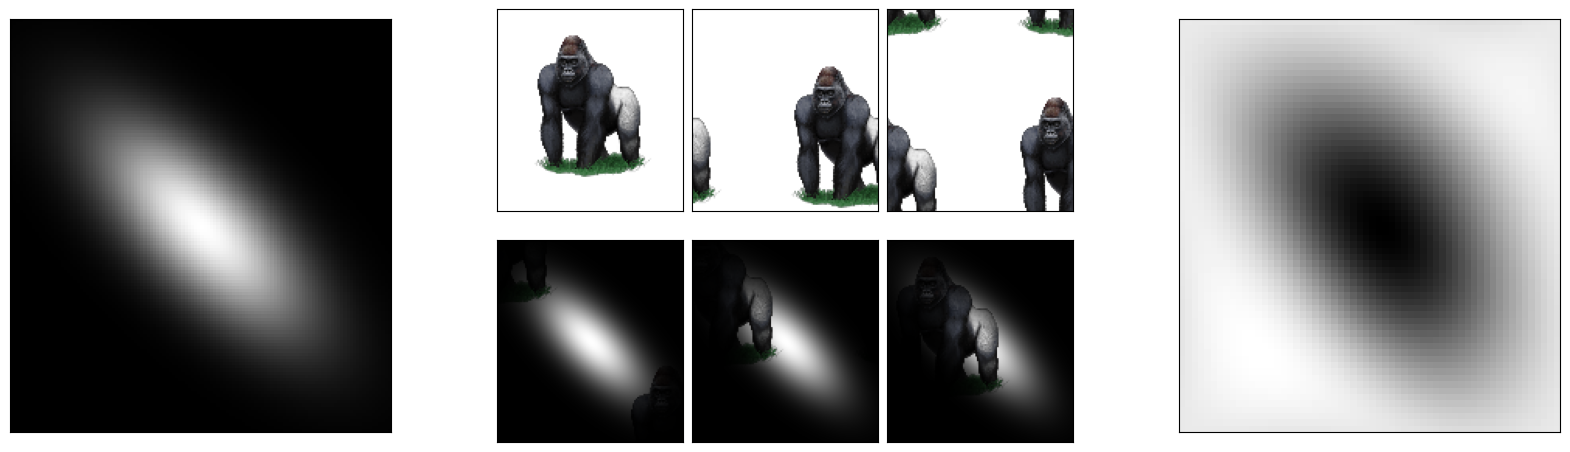

In [36]:
' Generate dataset - translated gorillas '

# Open image file and resize
img = plt.imread('Data/gorilla.png')
img = img[::7,::7,0:3]        # select 1 every 7 pixels
img = img[7:137,9:130]        # center image
nx, ny, _ = np.shape(img)
print('The RGB image has shape', np.shape(img))

# Translate image and flatten
Images = np.array([[np.roll(np.roll(img, i, 0), j, 1).flatten() for j in range(0,ny,2)] for i in range(0,nx,2)])
print('The point cloud (collection of translated images) has shape', np.shape(Images))

' Create regression target '

# Create dataset
sigma = 500*np.array([[1,0.7],[0.7,1]])
# sigma = 500*np.array([[1,0.6],[0.6,1]])
gaussian_filter, Images_conv, y = GaussianConvolution(shape=np.shape(img), sigma=sigma, X=Images)

# Dimension reduction
dim_pca = 50
X = Images.reshape(Images.shape[0]*Images.shape[1],Images.shape[2])
X = sklearn.decomposition.PCA(n_components=dim_pca).fit_transform(X)

# Splits data into training and test
y = y.reshape(-1)
# y = np.array([np.sin(j*np.pi/60)+np.sin(i*np.pi/65) for i in range(65) for j in range(60)]) # another task: geodesic distance to origin
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
print('Shape of train and test sets:', np.shape(X_train), np.shape(X_test))

# Plot
fig = plt.figure(figsize = (20,6)); fig.tight_layout()
gs = matplotlib.gridspec.GridSpec(2, 16); gs.update(wspace = 0.1, hspace = 0.0)
ax1 = plt.subplot(gs[0:2, 0:4])
ax2 = plt.subplot(gs[0:2, 12:16])
axs1 = [plt.subplot(gs[0, 5:7]),plt.subplot(gs[1, 5:7])]
axs2 = [plt.subplot(gs[0, 7:9]),plt.subplot(gs[1, 7:9])]
axs3 = [plt.subplot(gs[0, 9:11]),plt.subplot(gs[1, 9:11])]
for ax in [ax1,ax2]+axs1+axs2+axs3: 
        ax.get_xaxis().set_ticks([]); 
        ax.get_yaxis().set_ticks([]);
ax1.imshow(gaussian_filter, cmap='gray')
ax2.imshow(y.reshape(65,60), cmap='gray')
axs1[0].imshow(Images[0,0].reshape(np.shape(img)))
axs1[1].imshow(Images_conv[0,0].reshape(np.shape(img)))
axs1[0].imshow(Images[0,0].reshape(np.shape(img)))
axs1[1].imshow(Images_conv[0,0].reshape(np.shape(img)))
axs2[0].imshow(Images[10,20].reshape(np.shape(img)))
axs2[1].imshow(Images_conv[10,20].reshape(np.shape(img)))
axs3[0].imshow(Images[20,30].reshape(np.shape(img)))
axs3[1].imshow(Images_conv[20,30].reshape(np.shape(img)))
fig.savefig('Figures/harmonic_analysis_gaussianfilter_dataset.png',dpi=fig.dpi,bbox_inches='tight');

----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [0.00012813070001119664, 0.00021106143297783747, 0.12277755874244435, 0.12335718043280336]
Eigengap #2: 581.7147974890165
----> Optimization problem via NormalForm for torus group <----
The optimal frequencies found is ((1, 0), (0, 1)) with cost 2.3551386880256624e-16
Non-symmetric Hausdorff distance from point cloud to estimated orbit: 0.042129905084628924 
Non-symmetric Hausdorff distance from estimated orbit to point cloud: 0.08896785506448557


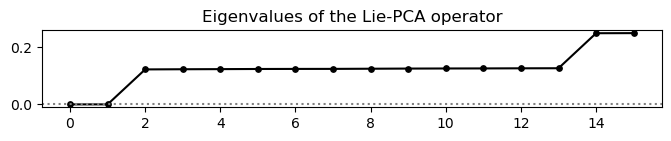

In [37]:
' LieDetect on train set '

# Orthonormalization
pca = sklearn.decomposition.PCA(n_components=4).fit(X_train)
X_train_orth, Cov = Orthonormalize(pca.transform(X_train))
# X_train_orth, Cov = X_train, np.eye(4)

# Lie-PCA
n_neighbors = 8
dim_LiePCA = 2
Sigma = GetLiePCAOperator(X_train_orth,n_neighbors,dim_LiePCA,method='localPCA',verbose=True)

# Plot Lie-PCA operator
vals = np.sort(np.real(np.linalg.eig(Sigma)[0]))[0:30]
fig = plt.figure(figsize=(8,1)); ax = fig.add_subplot()
ax.plot(range(len(vals)),vals,c='black'); ax.scatter(range(len(vals)), vals,c='black', s=15); 
ax.axhline(0,color='grey',linestyle='dotted'); 
ax.set_ylim((0-0.01,max(vals)+0.01)); ax.set_title('Eigenvalues of the Lie-PCA operator');

# LieDetect
group, dim = 'torus', 2
ambient_dim = 4
method_optim, FrequenciesToTest = 'NormalForm', [((1, 0), (0, 1))]
OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra(group,Sigma,dim,ambient_dim,FrequenciesToTest=FrequenciesToTest,method=method_optim,verbosity=1)

# Generate estimated orbit
# n_points_orbit = 300
n_points_orbit = 300
x = X_train_orth[0,:] #initial point
Orbit, CoordinatesOrbit = GenerateOrbitTorusWithCoordinates(OptimalLieAlgebra, OptimalFrequencies, n_points=n_points_orbit, x=x)

# Compute non-symmetric Hausdorff
Hausdorff = scipy.spatial.distance.directed_hausdorff(X_train_orth, Orbit)[0]
print('\x1b[1;31m'+'Non-symmetric Hausdorff distance from point cloud to estimated orbit:', Hausdorff,'\x1b[0m')
Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, X_train_orth)[0]
print('Non-symmetric Hausdorff distance from estimated orbit to point cloud:', Hausdorff)

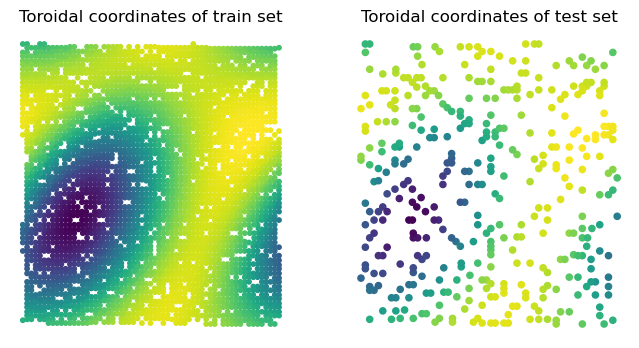

In [38]:
' Compute toroidal coordinates '

# Get toroidal coordinates of whole set
ToroidalCoordinatesAll = []
for i in range(np.shape(X)[0]):
    # ind_argmin = np.argmin(np.linalg.norm(Cov@X[i,:]-Orbit, axis=1))
    ind_argmin = np.argmin(np.linalg.norm(Cov@(pca.transform(X[i,:].reshape(1,-1)).T).reshape(-1)-Orbit, axis=1))
    ToroidalCoordinatesAll.append( CoordinatesOrbit[ind_argmin] )
ToroidalCoordinatesAll = np.array(ToroidalCoordinatesAll)

# Get toroidal coordinates of train set
ToroidalCoordinatesTrain = []
for i in range(np.shape(X_train)[0]):
    # ind_argmin = np.argmin(np.linalg.norm(Cov@X_train[i,:]-Orbit, axis=1))
    ind_argmin = np.argmin(np.linalg.norm(Cov@(pca.transform(X_train[i,:].reshape(1,-1)).T).reshape(-1)-Orbit, axis=1))
    ToroidalCoordinatesTrain.append( CoordinatesOrbit[ind_argmin] )
ToroidalCoordinatesTrain = np.array(ToroidalCoordinatesTrain)

# Get toroidal coordinates of test set
ToroidalCoordinatesTest = []
for i in range(np.shape(X_test)[0]):
    # ind_argmin = np.argmin(np.linalg.norm(Cov@X_test[i,:]-Orbit, axis=1))
    ind_argmin = np.argmin(np.linalg.norm(Cov@(pca.transform(X_test[i,:].reshape(1,-1)).T).reshape(-1)-Orbit, axis=1))
    ToroidalCoordinatesTest.append( CoordinatesOrbit[ind_argmin] )
ToroidalCoordinatesTest = np.array(ToroidalCoordinatesTest)

# Plot
fig = plt.figure(figsize=(4*2,4))
ax = fig.add_subplot(121); ax.set_title('Toroidal coordinates of train set',); ax.axis('off')
ax.scatter(ToroidalCoordinatesTrain[:,0],ToroidalCoordinatesTrain[:,1],c=y_train,s=10)
ax = fig.add_subplot(122); ax.set_title('Toroidal coordinates of test set'); ax.axis('off')
ax.scatter(ToroidalCoordinatesTest[:,0],ToroidalCoordinatesTest[:,1],c=y_test, s=20);
fig.savefig('Figures/toroidal_coordinates.png',dpi=fig.dpi,bbox_inches='tight');

Mean squared error (test set):  3.956356221485613e-05 
Mean squared error (all set):   3.2523418811818356e-05


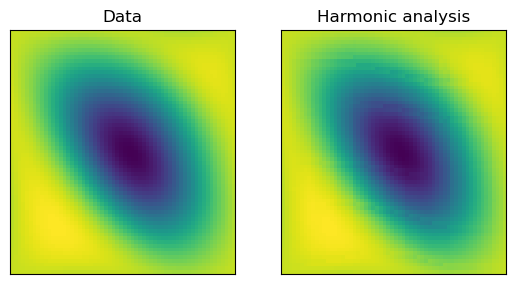

In [39]:
Scores = []

' Regression with harmonic analysis '

# Get indices of toroidal coordinates
N_1, N_2 = 65, 60
X_indices_all = np.array([ToroidalCoordinatesAll[:,0]/ToroidalCoordinatesAll.max()*N_1,ToroidalCoordinatesAll[:,1]/ToroidalCoordinatesAll.max()*N_2], dtype=int).T
X_indices_train = np.array([ToroidalCoordinatesTrain[:,0]/ToroidalCoordinatesTrain.max()*N_1,ToroidalCoordinatesTrain[:,1]/ToroidalCoordinatesTrain.max()*N_2], dtype=int).T
X_indices_test = np.array([ToroidalCoordinatesTest[:,0]/ToroidalCoordinatesTest.max()*N_1,ToroidalCoordinatesTest[:,1]/ToroidalCoordinatesTest.max()*N_2], dtype=int).T

# Train
beta = regression(X_indices_train, y_train, N_1=N_1, N_2=N_2, max_freq_fourrier=10) #estimate coefficients betas

# Predict
predictions_test = np.real(predict(X_indices_test, beta))   # Predictions on test set
predictions_all = np.real(predict(X_indices_all, beta))
mse = sum((predictions_test-y_test)**2)/len(y_test)
print('\x1b[1;31m'+'Mean squared error (test set): ', mse, '\x1b[0m')
Scores.append(('Toroidal coordinates', mse, predictions_all.copy()))

mse = sum((predictions_all-y)**2)/len(y)
print('Mean squared error (all set):  ', mse)

# Plot
fig, axs = plt.subplots(1,2)
for ax in axs: 
    ax.get_xaxis().set_ticks([]); 
    ax.get_yaxis().set_ticks([]);
axs[0].imshow(y.reshape(65,60)); axs[0].set_title('Data')
axs[1].imshow(predictions_all.reshape(65,60)); axs[1].set_title('Harmonic analysis');

Mean squared error (test set):  7.015994900961205e-05 
Mean squared error (all set):   2.038035705706665e-05


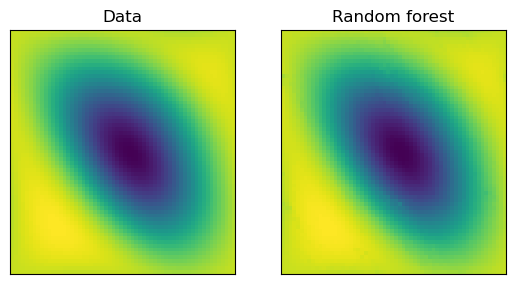

In [40]:
' Regression with random forest '

# Train
regr = RandomForestRegressor(random_state = 0).fit(X_train, y_train)

# Predict
predictions_test = regr.predict(X_test)    # Predictions on test set
predictions_all = regr.predict(X)  # Predictions on whole dataset
mse = sum((predictions_test-y_test)**2)/len(y_test)
print('\x1b[1;31m'+'Mean squared error (test set): ', mse, '\x1b[0m')
Scores.append(('Random forest', mse, predictions_all.copy()))

mse = sum((predictions_all-y)**2)/len(X)
print('Mean squared error (all set):  ', mse)

# Plot
fig, axs = plt.subplots(1,2)
for ax in axs: 
    ax.get_xaxis().set_ticks([]); 
    ax.get_yaxis().set_ticks([]);
axs[0].imshow(y.reshape(65,60)); axs[0].set_title('Data')
axs[1].imshow(predictions_all.reshape(65,60)); axs[1].set_title('Random forest');

Mean squared error (test set):  8.651230283579317e-05 
Mean squared error (all set):   8.856187362872535e-05


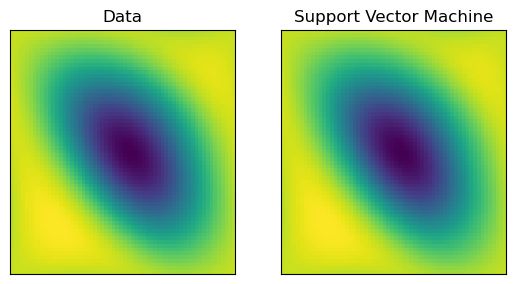

In [41]:
' Regression with SVM '

# Train
param_grid = {"SVR__C": [0.1, 1, 10, 100],
              "SVR__epsilon": [0.01, 0.1, 0.5, 1]}
regr = Pipeline(steps = [('scaler', StandardScaler()), ('SVR',SVR())])
grid = GridSearchCV(regr, param_grid, refit = True, verbose = 0)
grid.fit(X_train, y_train)

# Predict
predictions_test = grid.predict(X_test)  # Predictions on test set
predictions_all =  grid.predict(X)  # Predictions on whole dataset
mse = sum((predictions_test-y_test)**2)/len(y_test)
print('\x1b[1;31m'+'Mean squared error (test set): ', mse, '\x1b[0m')
Scores.append(('Support Vector Machine', mse, predictions_all.copy()))

mse = sum((predictions_all-y)**2)/len(y)
print('Mean squared error (all set):  ', mse)

# Plot
fig, axs = plt.subplots(1,2)
for ax in axs: 
    ax.get_xaxis().set_ticks([]); 
    ax.get_yaxis().set_ticks([]);
axs[0].imshow(y.reshape(65,60)); axs[0].set_title('Data')
axs[1].imshow(predictions_all.reshape(65,60)); axs[1].set_title('Support Vector Machine');

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step
Mean squared error (test set):  5.851723666491873e-05 
Mean squared error (all set):   5.1291922166562256e-05


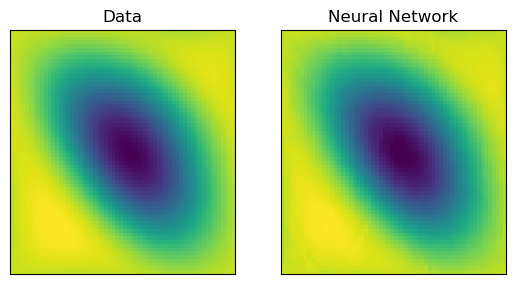

In [42]:
' Regression with MLP '

# Train 
model = feedforward(2,10,'relu',inputs_shape=50)
trains_network(model,300, X_train, y_train, plot= False)
IPython.display.clear_output()

# Predict
predictions_test = model.predict(X_test).reshape(-1)  # Predictions on test set
predictions_all =  model.predict(X).reshape(-1)  # Predictions on whole dataset
mse = sum((predictions_test-y_test)**2)/len(y_test)
print('\x1b[1;31m'+'Mean squared error (test set): ', mse, '\x1b[0m')
Scores.append(('Neural Network', mse, predictions_all.copy()))

mse = sum((predictions_all-y)**2)/len(y)
print('Mean squared error (all set):  ', mse)

# Plot
fig, axs = plt.subplots(1,2)
for ax in axs: 
    ax.get_xaxis().set_ticks([]); 
    ax.get_yaxis().set_ticks([]);
axs[0].imshow(y.reshape(65,60)); axs[0].set_title('Data')
axs[1].imshow(predictions_all.reshape(65,60)); axs[1].set_title('Neural Network');

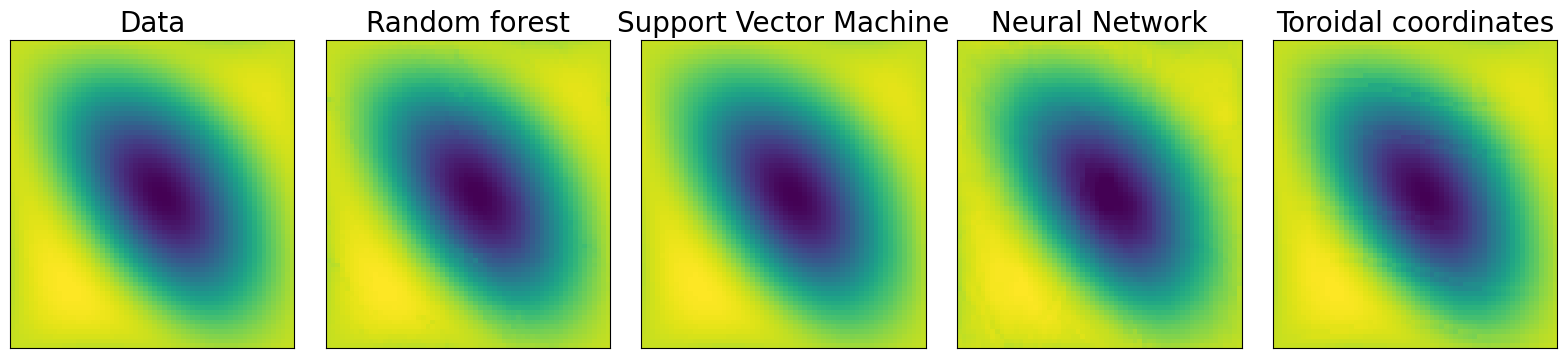

| Model | MSE on test data |
 | --- | --- | 
Random forest|0.000070160|
Support Vector Machine|0.000086512|
Neural Network|0.000058517|
Toroidal coordinates|0.000039564|

\begin{longtable}{||c|c||}\hline Model&MSE on test data\\*\hlineRandom forest&0.000070160\\Support Vector Machine&0.000086512\\Neural Network&0.000058517\\Toroidal coordinates&0.000039564\\*\hline\end{longtable}


In [43]:
' Show results '

Scores = [Scores[i] for i in [1,2,3,0]]

# Plot results
fig, axs = plt.subplots(1,5, figsize = (4*5, 4))
plt.subplots_adjust(wspace=0.1, hspace=0)
for ax in axs: 
    ax.get_xaxis().set_ticks([]); 
    ax.get_yaxis().set_ticks([]);
axs[0].imshow(y.reshape(65,60)); axs[0].set_title('Data', fontsize=20)
for i, score in enumerate(Scores):
    axs[i+1].imshow(score[2].reshape(65,60)); 
    axs[i+1].set_title(score[0], fontsize=20);
plt.show()
fig.savefig('Figures/harmonic_analysis_gaussianfilter_results.png',dpi=fig.dpi,bbox_inches='tight');

# Print scores in markdown and latex
str_markdown = '| Model | MSE on test data |\n | --- | --- | \n'\
                +'\n'.join([str(score[0])+'|'+'{:.9f}'.format(score[1])+'|' for score in Scores])
IPython.display.display_markdown(str_markdown, raw=True)
str_latex = '\\begin{longtable}{||c|c||}\\hline Model&MSE on test data\\\\*\\hline'\
+'\\\\'.join([str(score[0])+'&'+'{:.9f}'.format(score[1]) for score in Scores])\
+'\\\\*\\hline\\end{longtable}'
print(str_latex)

## III.2. Learning rotation matrices from armadillo, voxels embedding

In [44]:
def GenerateOrbitSU2WithCoordinates(LieAlgebra, frequencies, n_points, x):
    # Define coefficient and sanity check
    coefficient = 4*np.pi*np.linalg.norm(GetCanonicalLieAlgebraSU2(frequencies)[0])/2
    if any([np.linalg.norm(scipy.linalg.expm(coefficient*A)-np.eye(np.shape(A)[0]))>1e-5 for A in LieAlgebra]): 
        print('Error! Incorrect coefficient', coefficient)
        for A in LieAlgebra: print(np.linalg.norm(scipy.linalg.expm(coefficient*A)-np.eye(np.shape(A)[0])))

    # Generate first circle
    T = np.linspace(0,coefficient, n_points)
    Coordinates = np.array([ t for t in T])
    Orbit = np.array([ scipy.linalg.expm(t*LieAlgebra[0]) @ x for t in T])
    
    # Apply next transformations
    for i in range(1,3):
        Coordinates = [ (t,y) for y in Coordinates for t in T] 
        Orbit = np.concatenate([[ scipy.linalg.expm(t*LieAlgebra[i]) @ y for t in T] for y in Orbit])
        
    Coordinates = [(t[1][1],t[1][0], t[0]) for t in Coordinates]        
    return Orbit, Coordinates, coefficient

Compute voxel data... It 5000/5000. Duration 0:00:21 Expected remaining time 0:00:00.
Count (min/max): 971.1897580722066 1003.7202891508138
Count ticks (min/max): 3320 4408
----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [0.003918510495890138, 0.0072705024936377425, 0.007839891853221273, 0.047524664129773374]
Eigengap #3: 6.061903023604379


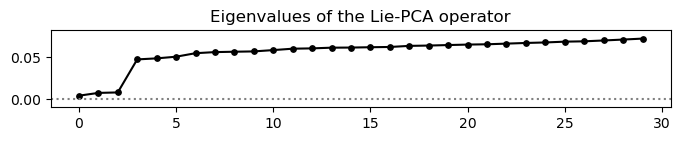

----> Optimization problem via Stiefel for SU(2) group <----
Solve minimization problem... It 1/1. Duration 0:02:12 Expected remaining time 0:00:00.
The optimal frequencies found is (3, 5) with cost 0.0002506373355057604
Non-symmetric Hausdorff distance from point cloud to estimated orbit: 0.3733794821019583 
Non-symmetric Hausdorff distance from estimated orbit to point cloud: 0.5099795504763789


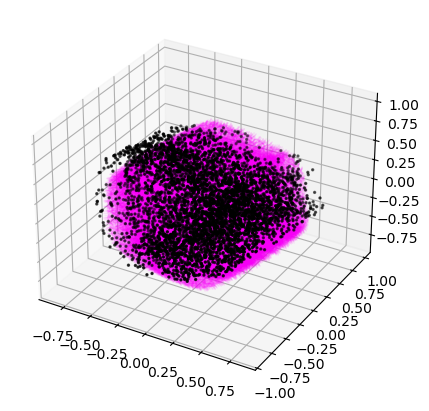

In [45]:
' LieDetect on armadillo in R^8 '

# Generate point cloud
name = 'armadillo'
method_data = 'voxels'
N_img = 5000
N_voxels = 20
N_points = 1000
X, Rotations, Directions, Angles = MakeDatasetFromMesh(name=name,method_data=method_data,N_img=N_img,N_points=N_points,
                                                       N_voxels=N_voxels,plot=False,return_Rotations=True)

# Dimension reduction
dim_pca = 8
Y = sklearn.decomposition.PCA(n_components=dim_pca).fit_transform(X)
Y -= np.mean(Y,0)
Y = np.array([p/np.linalg.norm(p) for p in Y])
Y, _ = Orthonormalize(Y)

# Lie-PCA
n_neighbors = 10
dim_LiePCA = 3
Sigma = GetLiePCAOperator(Y,n_neighbors,dim_LiePCA,method='localPCA',verbose=True)
vals = np.sort(np.real(np.linalg.eig(Sigma)[0]))[0:30]
fig = plt.figure(figsize=(8,1)); ax = fig.add_subplot()
ax.plot(range(len(vals)),vals,c='black'); ax.scatter(range(len(vals)), vals,c='black', s=15); 
ax.axhline(0,color='grey',linestyle='dotted'); 
ax.set_ylim((0-0.01,max(vals)+0.01)); ax.set_title('Eigenvalues of the Lie-PCA operator');
plt.show()

# LieDetect
group, dim = 'SU(2)', 3
ambient_dim = dim_pca
FrequenciesToTest = [(3, 5)]
method_optim = 'Stiefel'
OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra(group,Sigma,dim,ambient_dim,FrequenciesToTest=FrequenciesToTest,
                                                              method=method_optim,verbosity=1)

# Generate estimated orbit
n_points_orbit = 40
x = Y[0,:] #initial point of X
Orbit, CoordinatesOrbit, coefficient_rep = GenerateOrbitSU2WithCoordinates(OptimalLieAlgebra, OptimalFrequencies, n_points=n_points_orbit, x=x)

# Compute non-symmetric Hausdorff
Hausdorff = scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0]
print('\x1b[1;31m'+'Non-symmetric Hausdorff distance from point cloud to estimated orbit:', Hausdorff,'\x1b[0m')
Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, Y)[0]
print('Non-symmetric Hausdorff distance from estimated orbit to point cloud:', Hausdorff)

# Plot orbit
pca = sklearn.decomposition.PCA(n_components=3)
Ypca = pca.fit_transform(Y)
fig = plt.figure(figsize=(5,5)); ax = fig.add_subplot(projection='3d')
ax.scatter(Ypca[:,0], Ypca[:,1], Ypca[:,2], c='black', s=2);
Orbitpca = pca.transform(Orbit)
ax.plot(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=0.4, alpha=0.1,marker="3");

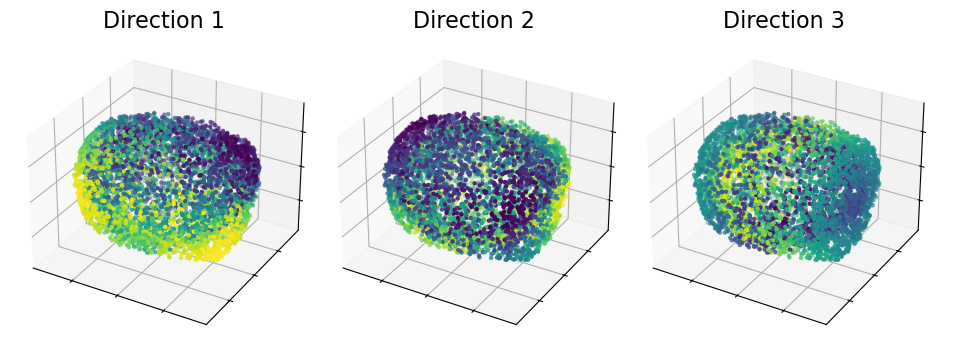

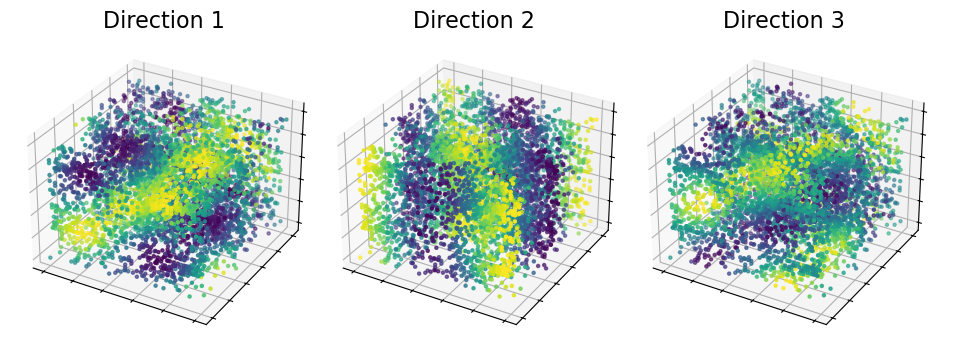

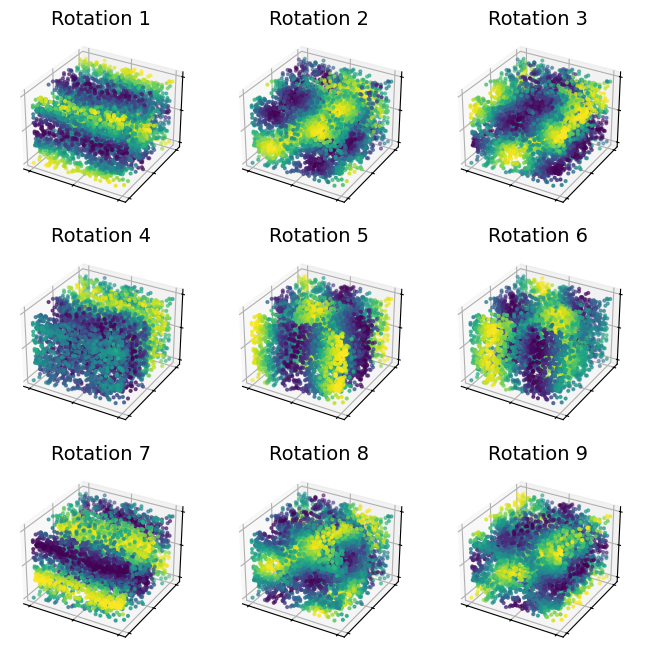

In [46]:
' Plot objectives '

# Plot objectives
fontsize = 16
# fig = plt.figure(figsize=(4*4,4))
fig = plt.figure(figsize=(3*4,4))
plt.subplots_adjust(wspace=0, hspace=0.0)
Xpca = sklearn.decomposition.PCA(n_components=3).fit_transform(X)
for i in range(3):
    ax = fig.add_subplot(1,3,i+1,projection='3d')
    ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c=Directions[:,i], s=5);
    ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([]);
    ax.set_title('Direction '+repr(i+1),fontsize=fontsize)
fig.savefig('Figures/armadillo_coordinates_objective.png',dpi=fig.dpi,bbox_inches='tight');

# Define SU(2) coordinates on the point cloud
Coordinates = []
for i in range(np.shape(X)[0]):
    ind_argmin = np.argmin(np.linalg.norm(Y[i,:]-Orbit, axis=1))
    Coordinates.append( CoordinatesOrbit[ind_argmin]/coefficient_rep )
Coordinates = np.array(Coordinates)

# Plot SU(2) coordinates - Directions and Angles
fontsize = 16
fig = plt.figure(figsize=(3*4,4))
plt.subplots_adjust(wspace=0, hspace=0.0)
for i in range(3):
    ax = fig.add_subplot(1,3,i+1,projection='3d')
    ax.scatter(Coordinates[:,0], Coordinates[:,1], Coordinates[:,2], c=Directions[:,i], s=5);
    ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([]);
    ax.set_title('Direction '+repr(i+1),fontsize=fontsize)
ax.set_xticklabels([]); ax.set_yticklabels([]);  ax.set_zticklabels([]);
fig.savefig('Figures/armadillo_coordinates_directionsincoordinates.png',dpi=fig.dpi,bbox_inches='tight');

# Plot SU(2) coordinates - Rotations
fontsize = 14
fig = plt.figure(figsize=(4*2,4*2))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
for i in range(3*3):
    ax = fig.add_subplot(3,3,i+1,projection='3d')
    R = Rotations[:,i]; R -= R.min(); R /= R.max();
    ax.scatter(Coordinates[:,0], Coordinates[:,1], Coordinates[:,2], c=R, s=4);
    ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([]);
    ax.set_title('Rotation '+repr(i+1),fontsize=fontsize)
fig.savefig('Figures/armadillo_coordinates_rotationsincoordinates.png',dpi=fig.dpi,bbox_inches='tight');

In [47]:
' Compute scores '

Scores = []
param_grid = {'SVR__C': [1, 10, 100], 'SVR__epsilon': [0.1, 1]}

# Estimate from whole embedding
for dim_pca in range(3,10+1):
    name = 'SVM in dimension '+repr(dim_pca); print(name)
    input_data = sklearn.decomposition.PCA(n_components=dim_pca).fit_transform(X)
    score = []
    for output_data in [Directions[:,0],Directions[:,1],Directions[:,2],Angles]:
        # Train
        X_train, X_test, y_train, y_test = train_test_split(input_data, list(output_data), test_size=0.1, random_state=42)    
        regr = Pipeline(steps = [('scaler', StandardScaler()), ('SVR',SVR())])
        grid = GridSearchCV(regr, param_grid, refit = True, verbose = 0)
        grid.fit(X_train, y_train)

        # Predict
        predictions_test = grid.predict(X_test)    # Predictions on test set
        mse = np.mean((predictions_test-y_test)**2)
        score.append(mse)
        print('\x1b[1;31m'+'Mean squared error (test set): ', mse, '\x1b[0m')
        predictions_train = grid.predict(X_train)  # Predictions on train set
        mse = np.mean((predictions_train-y_train)**2)
        print('Mean squared error (train set): ', mse)
    Scores.append([name]+score)

# Estimate from SU(2) coordinates 
name = 'SVM on coordinates'; print(name)
input_data = Coordinates
score = []
for output_data in [Directions[:,0],Directions[:,1],Directions[:,2],Angles]:
    # Train
    X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.1, random_state=42)    
    regr = Pipeline(steps = [('scaler', StandardScaler()), ('SVR',SVR())])
    grid = GridSearchCV(regr, param_grid, refit = True, verbose = 0)
    grid.fit(X_train, y_train)

    # Predict
    predictions_test = grid.predict(X_test)    # Predictions on test set
    mse = np.mean((predictions_test-y_test)**2)
    score.append(mse)
    print('\x1b[1;31m'+'Mean squared error (test set): ', mse, '\x1b[0m')
    predictions_train = grid.predict(X_train)  # Predictions on train set
    mse = np.mean((predictions_train-y_train)**2)
    print('Mean squared error (train set): ', mse)
Scores.append([name]+score)

IPython.display.clear_output()

# Print scores in markdown and latex 
Scores = [[score[0], sum(score[1:4]), score[4]] for score in Scores]
str_markdown = '| Model | MSE direction | MSE angle | \n | --- | --- | --- | \n'\
                +'\n'.join([str(score[0])+'|'+'{:.4f}'.format(score[1])+'|'+'{:.4f}'.format(score[2])+'|' for score in Scores])
IPython.display.display_markdown(str_markdown, raw=True)

# Print scores only direction
str_markdown = '| Model | MSE on test data | \n | --- | ---  \n'\
                +'\n'.join([str(score[0])+'|'+'{:.4f}'.format(score[1])+'|' for score in Scores])
IPython.display.display_markdown(str_markdown, raw=True)
str_latex = '\\begin{longtable}{||c|c||}\\hline Model&MSE on test data\\\\*\\hline '\
+' \\\\ '.join([str(score[0])+'&'+'{:.4f}'.format(score[1]) for score in Scores])\
+'\\\\*\\hline\\end{longtable}'
print(str_latex)

| Model | MSE direction | MSE angle | 
 | --- | --- | --- | 
SVM in dimension 3|0.4285|0.1186|
SVM in dimension 4|0.2566|0.0530|
SVM in dimension 5|0.1279|0.0249|
SVM in dimension 6|0.0419|0.0064|
SVM in dimension 7|0.0164|0.0038|
SVM in dimension 8|0.0112|0.0042|
SVM in dimension 9|0.0108|0.0040|
SVM in dimension 10|0.0111|0.0042|
SVM on coordinates|0.0065|0.0028|

| Model | MSE on test data | 
 | --- | ---  
SVM in dimension 3|0.4285|
SVM in dimension 4|0.2566|
SVM in dimension 5|0.1279|
SVM in dimension 6|0.0419|
SVM in dimension 7|0.0164|
SVM in dimension 8|0.0112|
SVM in dimension 9|0.0108|
SVM in dimension 10|0.0111|
SVM on coordinates|0.0065|

\begin{longtable}{||c|c||}\hline Model&MSE on test data\\*\hline SVM in dimension 3&0.4285 \\ SVM in dimension 4&0.2566 \\ SVM in dimension 5&0.1279 \\ SVM in dimension 6&0.0419 \\ SVM in dimension 7&0.0164 \\ SVM in dimension 8&0.0112 \\ SVM in dimension 9&0.0108 \\ SVM in dimension 10&0.0111 \\ SVM on coordinates&0.0065\\*\hline\end{longtable}


## III.3. Learning rotation matrices from armadillo, KDE embedding

Compute voxel data... It 5000/5000. Duration 0:08:03 Expected remaining time 0:00:00.
Count (min/max): 846.9873464799747 857.3369799210113
Count ticks (min/max): 8000 8000
----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [0.003198698689800479, 0.0032690923664104587, 0.0034102411500728765, 0.05280930972604793]
Eigengap #3: 15.485505980983016


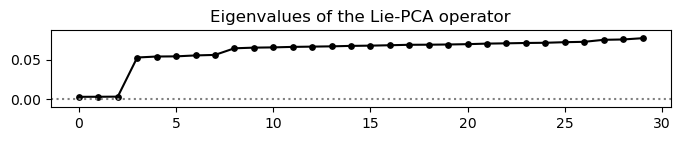

----> Optimization problem via Stiefel for SU(2) group <----
Solve minimization problem... It 1/1. Duration 0:01:22 Expected remaining time 0:00:00.
The optimal frequencies found is (3, 5) with cost 4.6180178860417154e-05
Non-symmetric Hausdorff distance from point cloud to estimated orbit: 0.11530391137340487 
Non-symmetric Hausdorff distance from estimated orbit to point cloud: 0.3657509030429086


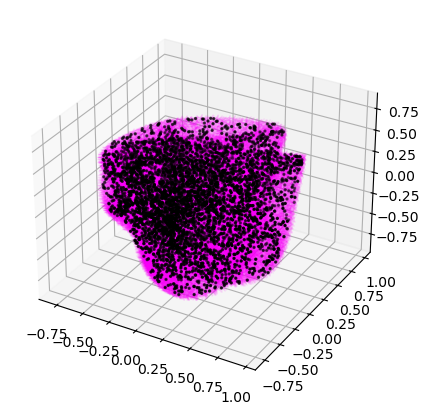

In [48]:
' LieDetect on armadillo in R^8 '

# Generate point cloud
name = 'armadillo'
method_data = 'kde'
N_img = 5000
N_voxels = 20
N_points = 1000
bw = .25
X, Rotations, Directions, Angles = MakeDatasetFromMesh(name=name,method_data=method_data,N_img=N_img,N_voxels=N_voxels,
                                                       N_points=N_points,bw=bw,plot=False,return_Rotations=True)

# Dimension reduction
dim_pca = 8
Y = sklearn.decomposition.PCA(n_components=dim_pca).fit_transform(X)
Y -= np.mean(Y,0)
Y, _ = Orthonormalize(Y)
Y = np.array([p/np.linalg.norm(p) for p in Y])

# Lie-PCA
n_neighbors = 10
dim_LiePCA = 3
Sigma = GetLiePCAOperator(Y,n_neighbors,dim_LiePCA,method='localPCA',verbose=True)
vals = np.sort(np.real(np.linalg.eig(Sigma)[0]))[0:30]
fig = plt.figure(figsize=(8,1)); ax = fig.add_subplot()
ax.plot(range(len(vals)),vals,c='black'); ax.scatter(range(len(vals)), vals,c='black', s=15); 
ax.axhline(0,color='grey',linestyle='dotted'); 
ax.set_ylim((0-0.01,max(vals)+0.01)); ax.set_title('Eigenvalues of the Lie-PCA operator');
plt.show()

# LieDetect
group, dim = 'SU(2)', 3
ambient_dim = dim_pca
FrequenciesToTest = [(3, 5)]
method_optim = 'Stiefel'
OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra(group,Sigma,dim,ambient_dim,FrequenciesToTest=FrequenciesToTest,
                                                              method=method_optim,verbosity=1)

# Generate estimated orbit
n_points_orbit = 40
x = Y[0,:] #initial point of X
Orbit, CoordinatesOrbit, coefficient_rep = GenerateOrbitSU2WithCoordinates(OptimalLieAlgebra, OptimalFrequencies, n_points=n_points_orbit, x=x)

# Compute non-symmetric Hausdorff
Hausdorff = scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0]
print('\x1b[1;31m'+'Non-symmetric Hausdorff distance from point cloud to estimated orbit:', Hausdorff,'\x1b[0m')
Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, Y)[0]
print('Non-symmetric Hausdorff distance from estimated orbit to point cloud:', Hausdorff)

# Plot orbit
pca = sklearn.decomposition.PCA(n_components=3)
Ypca = pca.fit_transform(Y)
fig = plt.figure(figsize=(5,5)); ax = fig.add_subplot(projection='3d')
ax.scatter(Ypca[:,0], Ypca[:,1], Ypca[:,2], c='black', s=2);
Orbitpca = pca.transform(Orbit)
ax.plot(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=0.4, alpha=0.1,marker="3");

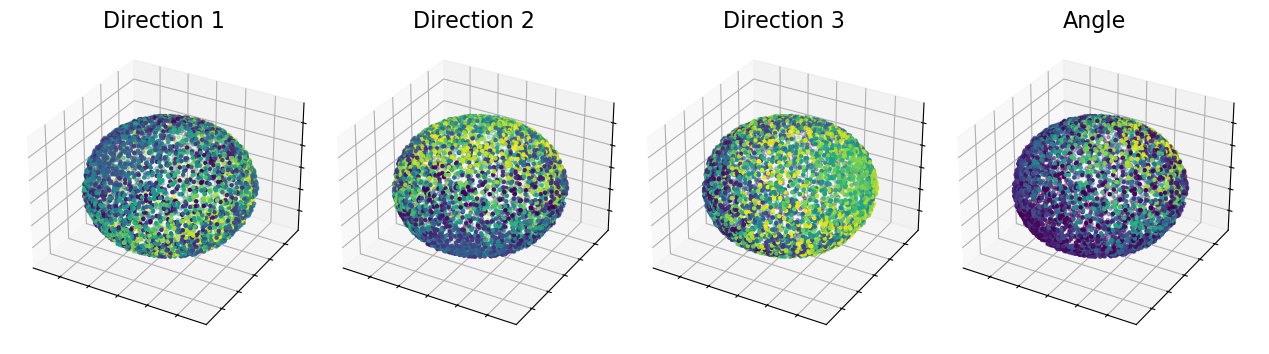

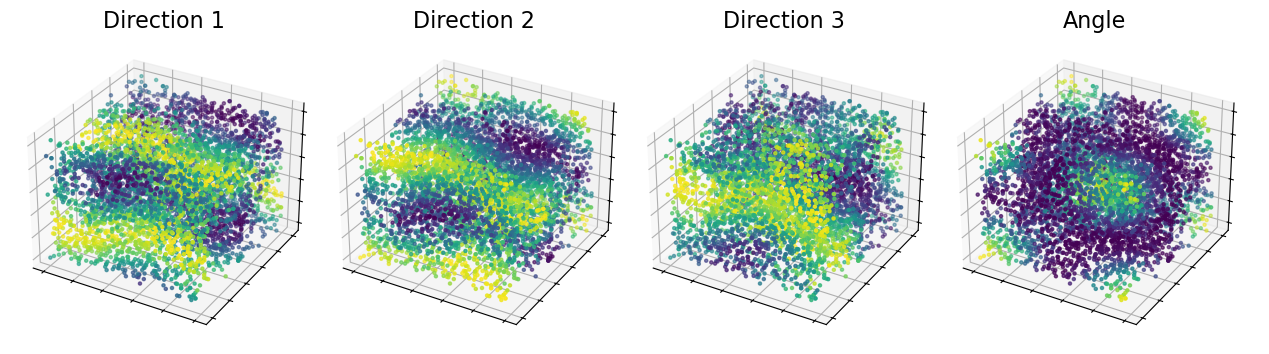

In [49]:
' Plot objectives '

# Plot objectives
fontsize = 16
fig = plt.figure(figsize=(4*4,4))
plt.subplots_adjust(wspace=0, hspace=0.0)
Xpca = sklearn.decomposition.PCA(n_components=3).fit_transform(X)
for i in range(3):
    ax = fig.add_subplot(1,4,i+1,projection='3d')
    ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c=Directions[:,i], s=5);
    ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([]);
    ax.set_title('Direction '+repr(i+1),fontsize=fontsize)
ax = fig.add_subplot(144,projection='3d')
ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c=Angles, s=5);
ax.set_xticklabels([]); ax.set_yticklabels([]);  ax.set_zticklabels([]);
ax.set_title('Angle',fontsize=fontsize)

# Define SU(2) coordinates on the point cloud
Coordinates = []
for i in range(np.shape(X)[0]):
    ind_argmin = np.argmin(np.linalg.norm(Y[i,:]-Orbit, axis=1))
    Coordinates.append( CoordinatesOrbit[ind_argmin]/coefficient_rep )
Coordinates = np.array(Coordinates)

# Plot SU(2) coordinates - Directions and Angles
fontsize = 16
fig = plt.figure(figsize=(4*4,4))
plt.subplots_adjust(wspace=0, hspace=0.0)
for i in range(3):
    ax = fig.add_subplot(1,4,i+1,projection='3d')
    ax.scatter(Coordinates[:,0], Coordinates[:,1], Coordinates[:,2], c=Directions[:,i], s=5);
    ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([]);
    ax.set_title('Direction '+repr(i+1),fontsize=fontsize)
ax = fig.add_subplot(144,projection='3d')
ax.scatter(Coordinates[:,0], Coordinates[:,1], Coordinates[:,2], c=Angles, s=5);
ax.set_xticklabels([]); ax.set_yticklabels([]);  ax.set_zticklabels([]);
ax.set_title('Angle',fontsize=fontsize);

In [51]:
' Compute scores '

Scores = []
param_grid = {'SVR__C': [1, 10, 100], 'SVR__epsilon': [0.1, 1]}

# Estimate from whole embedding
for dim_pca in range(3,10+1):
    name = 'SVM in dimension '+repr(dim_pca); print(name)
    input_data = sklearn.decomposition.PCA(n_components=dim_pca).fit_transform(X)
    score = []
    for output_data in [Directions[:,0],Directions[:,1],Directions[:,2],Angles]:
        # Train
        X_train, X_test, y_train, y_test = train_test_split(input_data, list(output_data), test_size=0.1, random_state=42)    
        regr = Pipeline(steps = [('scaler', StandardScaler()), ('SVR',SVR())])
        grid = GridSearchCV(regr, param_grid, refit = True, verbose = 0)
        grid.fit(X_train, y_train)

        # Predict
        predictions_test = grid.predict(X_test)    # Predictions on test set
        mse = np.mean((predictions_test-y_test)**2)
        score.append(mse)
        print('\x1b[1;31m'+'Mean squared error (test set): ', mse, '\x1b[0m')
        predictions_train = grid.predict(X_train)  # Predictions on train set
        mse = np.mean((predictions_train-y_train)**2)
        print('Mean squared error (train set): ', mse)
    Scores.append([name]+score)

# Estimate from SU(2) coordinates 
name = 'SVM on coordinates'; print(name)
input_data = Coordinates
score = []
for output_data in [Directions[:,0],Directions[:,1],Directions[:,2],Angles]:
    # Train
    X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.1, random_state=42)    
    regr = Pipeline(steps = [('scaler', StandardScaler()), ('SVR',SVR())])
    grid = GridSearchCV(regr, param_grid, refit = True, verbose = 0)
    grid.fit(X_train, y_train)

    # Predict
    predictions_test = grid.predict(X_test)    # Predictions on test set
    mse = np.mean((predictions_test-y_test)**2)
    score.append(mse)
    print('\x1b[1;31m'+'Mean squared error (test set): ', mse, '\x1b[0m')
    predictions_train = grid.predict(X_train)  # Predictions on train set
    mse = np.mean((predictions_train-y_train)**2)
    print('Mean squared error (train set): ', mse)
Scores.append([name]+score)

IPython.display.clear_output()

# Print scores in markdown and latex 
Scores = [[score[0], np.sqrt(sum(score[1:4])), score[4]] for score in Scores]
str_markdown = '| Model | MSE direction | MSE angle | \n | --- | --- | --- | \n'\
                +'\n'.join([str(score[0])+'|'+'{:.4f}'.format(score[1])+'|'+'{:.4f}'.format(score[2])+'|' for score in Scores])
IPython.display.display_markdown(str_markdown, raw=True)
str_latex = '\\begin{longtable}{||c|c|c|c|c||}\\hline Model&MSE direction&MSE angle\\\\*\\hline'\
+'\\\\'.join([str(score[0])+'&'+'{:.4f}'.format(score[1])+'&'+'{:.4f}'.format(score[2]) for score in Scores])\
+'\\\\*\\hline\\end{longtable}'
print(str_latex)

| Model | MSE direction | MSE angle | 
 | --- | --- | --- | 
SVM in dimension 3|0.8584|0.1516|
SVM in dimension 4|0.6923|0.1230|
SVM in dimension 5|0.4556|0.0473|
SVM in dimension 6|0.2869|0.0129|
SVM in dimension 7|0.1046|0.0043|
SVM in dimension 8|0.1277|0.0048|
SVM in dimension 9|0.1185|0.0050|
SVM in dimension 10|0.1133|0.0051|
SVM on coordinates|0.0847|0.0020|

\begin{longtable}{||c|c|c|c|c||}\hline Model&MSE direction&MSE angle\\*\hlineSVM in dimension 3&0.8584&0.1516\\SVM in dimension 4&0.6923&0.1230\\SVM in dimension 5&0.4556&0.0473\\SVM in dimension 6&0.2869&0.0129\\SVM in dimension 7&0.1046&0.0043\\SVM in dimension 8&0.1277&0.0048\\SVM in dimension 9&0.1185&0.0050\\SVM in dimension 10&0.1133&0.0051\\SVM on coordinates&0.0847&0.0020\\*\hline\end{longtable}
